# HCI Course 2024, ETH Zurich

<div class="alert alert-block alert-danger">

<h3> DEADLINE: 6th of January 2024 </h3>

Make sure this is in your github repo. Make sure that all the answers are saved within, so that we do not have to rerun your code.
Your code should be able to run, purely from this notebook.  

This is **part 2** of the bonus exercise. **Two bonus exercises combined are 25P in total**. The max bonus on the project grade is +0.25 for the full 25 points. You need to complete both exercise correctly to get the 25P.

This notebook wont be part of the exam, but the lecture on Bayesian optimization will be. Therefore this notebook could provide additional practice.

## Bonus Exercise 2: Bayesian Optimization for UI Optimization and Adaptation [10P in total]
### Yi-Chi Liao

## 1. Installation, import, and visualization

Before running the notebook, make sure you install the libraries correctly. We just need numpy, scipy, and matplotlib. If you don't have them yet, you can install them via the below two ways.

1. *pip install -r requirements.txt* 
2. *conda env create -f environment.yml*

If you have any questions regarding installation, please contact Yi-Chi (yichi.liao@inf.ethz.ch)

Just import and plot functions. Do not change anything in this seciton.


In [73]:
import numpy as np
from numpy import sin
import scipy
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

print(np.__version__)
print(scipy.__version__)
print(matplotlib.__version__)

2.0.0
1.14.0
3.9.0


In [74]:
def plot_gp_and_acquisition(true_function, gp_model, sample_x_list, sample_y_list, sample_points, acquisition_values=None, acq_x_range=None):
    """
    Plot the true function values, GP mean, GP variance, and acquisition function values in a 1D Bayesian Optimization setting.
    """
    # Calculate true function values over the specified sample points
    true_y = true_function(sample_points)
    
    # GP posterior predictions
    gp_y, gp_std = gp_model.predict(sample_points.reshape(-1, 1))
    
    # Plot observations and GP posterior
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    # Plot the GP mean and confidence interval
    axs[0].fill_between(
        sample_points,
        (gp_y - 1.96 * gp_std).ravel(),
        (gp_y + 1.96 * gp_std).ravel(),
        alpha=0.3,
        label="95% confidence interval",
    )
    axs[0].plot(sample_points, true_y, label='True Function', color='black')
    axs[0].plot(sample_points, gp_y, label='GP Mean', color='blue')
    
    # Plot sampled points, highlighting the latest sample in red
    for i, (x, y) in enumerate(zip(sample_x_list, sample_y_list)):
        color = 'red' if i == len(sample_x_list) - 1 else 'blue'
        axs[0].scatter(x, y, color=color)
    
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('Objective Function')
    axs[0].set_title('Observation')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot acquisition function if provided
    if acquisition_values is not None and acq_x_range is not None:
        axs[1].plot(acq_x_range, acquisition_values, color='purple')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('Acquisition Function Value')
        axs[1].set_title('Acquisition Function')
        axs[1].grid(True)
    
    plt.show()

In [75]:
def plot_2d_gp_and_acquisition(true_function, gp_model, sample_x_list, sample_y_list, bounds, acquisition_function, **acq_kwargs):
    """
    Plot 2D heatmaps for the true function values, GP mean, GP variance, and acquisition function values in a 2D Bayesian Optimization setting.
    """
    
    # Define a grid within the bounds for plotting
    x = np.linspace(bounds[0][0], bounds[0][1], 50)
    y = np.linspace(bounds[1][0], bounds[1][1], 50)
    X, Y = np.meshgrid(x, y)
    xy_grid = np.vstack([X.ravel(), Y.ravel()]).T

    # Calculate true function values over the grid
    Z_true = np.array([true_function(point) for point in xy_grid]).reshape(X.shape)

    # Calculate GP mean and variance over the grid
    Z_gp_mean, Z_gp_std = gp_model.predict(xy_grid)
    Z_gp_mean = Z_gp_mean.reshape(X.shape)
    Z_gp_var = (Z_gp_std ** 2).reshape(X.shape)

    # Calculate acquisition values over the grid
    Z_acq = np.array([float(acquisition_function(point.reshape(1, -1), gp_model, np.max(sample_y_list), **acq_kwargs)) for point in xy_grid]).reshape(X.shape)

    # Plot the true function values, GP mean, GP variance, and acquisition function heatmaps
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot the true function values heatmap with sample points
    c1 = axs[0, 0].imshow(Z_true, extent=(bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]),
                          origin='lower', cmap='viridis', aspect='auto')
    for i, point in enumerate(sample_x_list):
        color = 'red' if i == len(sample_x_list) - 1 else 'blue'
        axs[0, 0].scatter(point[0], point[1], color=color)
    axs[0, 0].set_title("True Function with Sample Points")
    axs[0, 0].set_xlabel("X1")
    axs[0, 0].set_ylabel("X2")
    fig.colorbar(c1, ax=axs[0, 0], orientation='vertical')

    # Plot the GP mean heatmap
    c2 = axs[0, 1].imshow(Z_gp_mean, extent=(bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]),
                          origin='lower', cmap='coolwarm', aspect='auto')
    axs[0, 1].set_title("GP Mean")
    axs[0, 1].set_xlabel("X1")
    axs[0, 1].set_ylabel("X2")
    fig.colorbar(c2, ax=axs[0, 1], orientation='vertical')

    # Plot the GP variance heatmap
    c3 = axs[1, 0].imshow(Z_gp_var, extent=(bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]),
                          origin='lower', cmap='YlGnBu', aspect='auto')
    axs[1, 0].set_title("GP Variance")
    axs[1, 0].set_xlabel("X1")
    axs[1, 0].set_ylabel("X2")
    fig.colorbar(c3, ax=axs[1, 0], orientation='vertical')

    # Plot the acquisition function heatmap
    c4 = axs[1, 1].imshow(Z_acq, extent=(bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]),
                          origin='lower', cmap='inferno', aspect='auto')
    axs[1, 1].set_title("Acquisition Function")
    axs[1, 1].set_xlabel("X1")
    axs[1, 1].set_ylabel("X2")
    fig.colorbar(c4, ax=axs[1, 1], orientation='vertical')

    plt.tight_layout()
    plt.show()

def plot_true_function(true_function, bounds, title="True Function with Sample Points"):
    """
    Plot the true objective function values as a 2D heatmap, with sample points overlayed.
    """
    # Define a grid within the bounds for plotting
    x = np.linspace(bounds[0][0], bounds[0][1], 50)
    y = np.linspace(bounds[1][0], bounds[1][1], 50)
    X, Y = np.meshgrid(x, y)
    xy_grid = np.vstack([X.ravel(), Y.ravel()]).T

    # Calculate true function values over the grid
    Z_true = np.array([true_function(point) for point in xy_grid]).reshape(X.shape)

    # Plot the true function values heatmap with sample points
    plt.figure(figsize=(6, 5))
    c = plt.imshow(Z_true, extent=(bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]),
                   origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(c, label="Function Value")
    
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()


## YOUR TASKS

There are four tasks within this notebook. 
- TASK 0: Complete the RBF Kernel ([Go to TASK 0](#TASK0)).
- TASK 1: Complete the Matern Kernel (3P) ([Go to TASK 1](#TASK1)).
- TASK 2: Improve the optimization performance (3P) ([Go to TASK 2](#TASK2)).
- TASK 3: Complete compute_hypervolume for multi-objective optimization (3P) ([Go to TASK 3](#TASK3)).
- TASK 4: Reflection -- where and how Bayesian optimization can be utilized to help your project make better design decisions? (1P) ([Go to TASK 4](#TASK4)).

## 2. Basic Bayesian optimization: Gaussian Process, RBF, and EI

### 2.1 A simple function and setting the problem

In [76]:
# Below, we define a function, which takes 1D input and gives 1D output

def simple_test_objective(x):
    return -(1.4 - 3.0 * x) * sin(18.0 * x)

# We specify the input range as [0, 1.2]
simple_bounds_1d = [(0, 1.2)]


Can you guess where the peak is within 10 trials? Any output y > 1.8 is good enough.

Remember, every try needs to fall into the range of (0, 1.2). 

Try out in the next cell! 

Iteration: 1


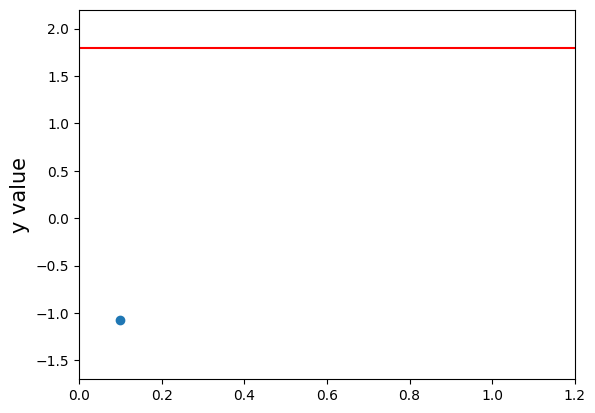

Iteration: 2


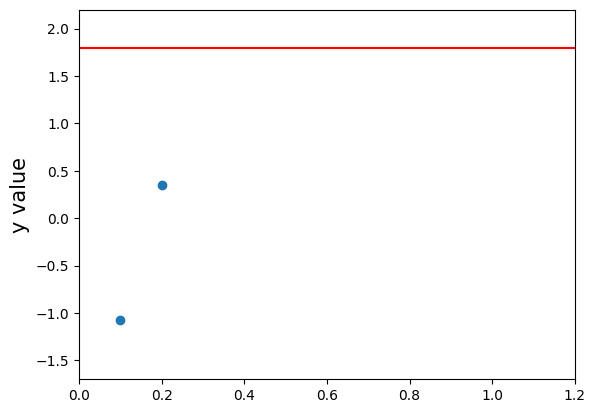

Iteration: 3


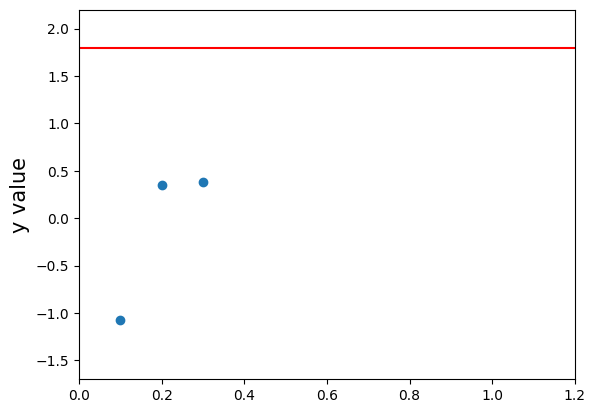

Iteration: 4


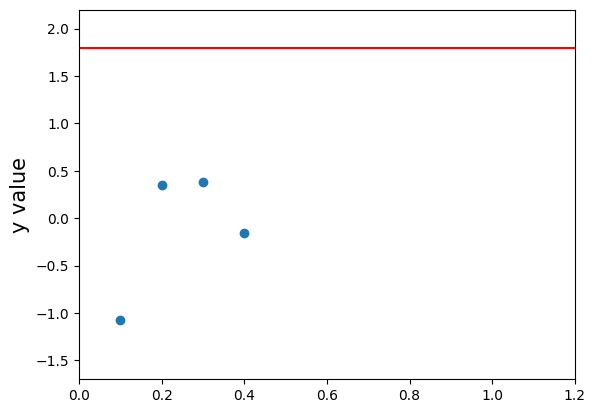

Iteration: 5


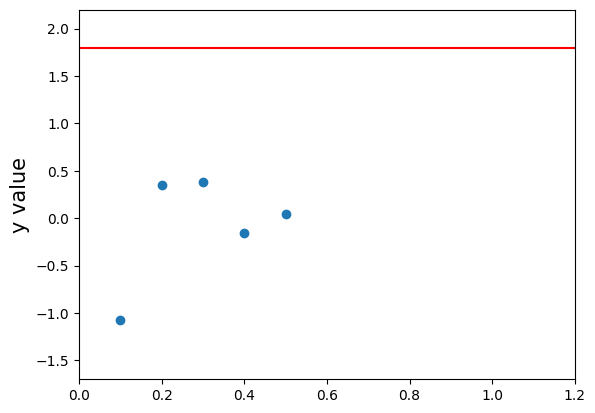

Iteration: 6


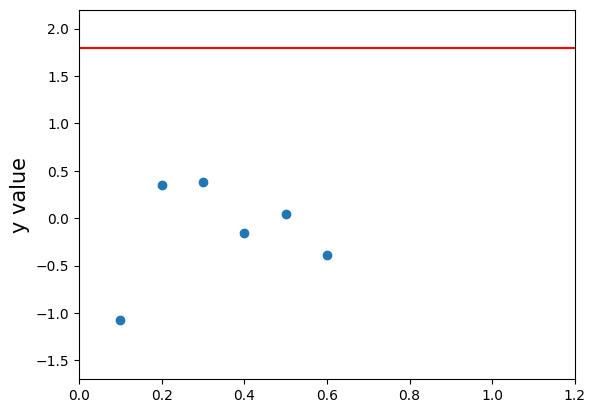

Iteration: 7


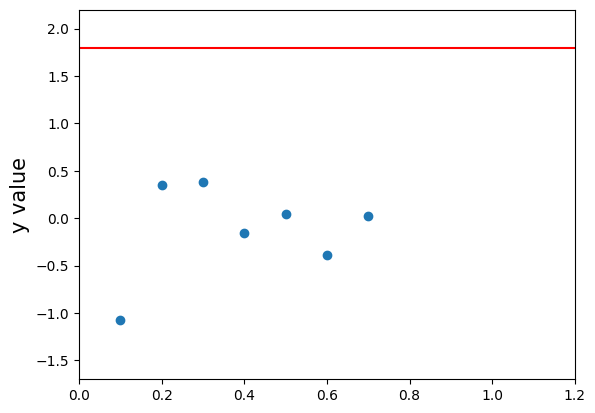

Iteration: 8


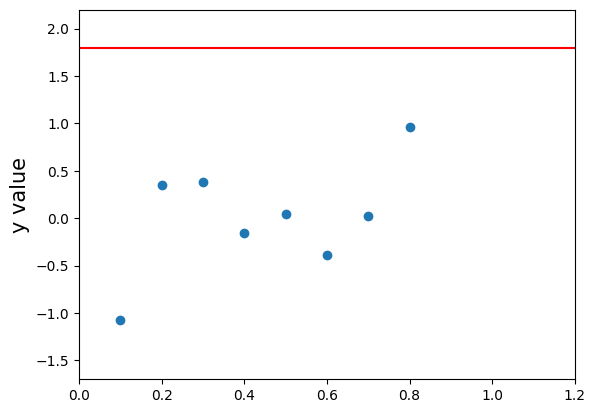

Iteration: 9


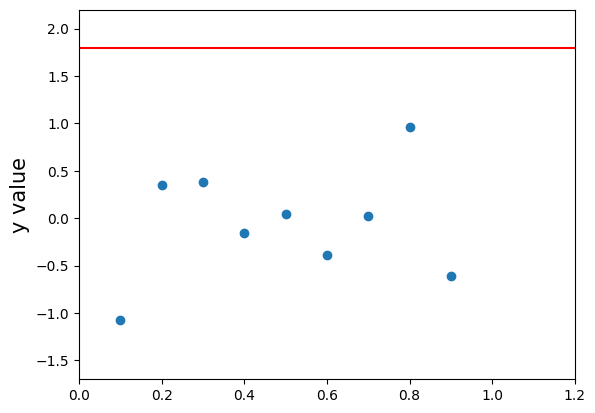

Iteration: 10


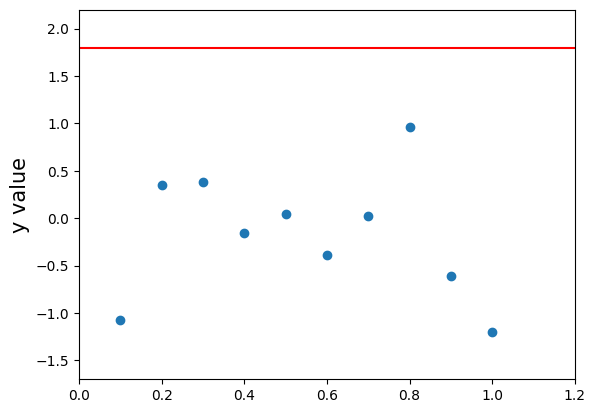

In [77]:
xs = []
for i in range(10):
    print(f"Iteration: {i+1}")
    this_x = input("Enter any value (0, 1.2): ")
    xs.append(float(this_x))
    np_xs = np.array(xs)
    ys = simple_test_objective(np_xs)
    
    plt.scatter(np_xs, ys)
    plt.xlim(0,1.2)
    plt.ylim(-1.7, 2.2)
    plt.ylabel('y value', fontsize=15)
    plt.axhline(y = 1.8, color = 'r', linestyle = '-')
    plt.show()

### 2.1 Gaussian Process

Now, we start implementing the base functions for Bayesian optimization.

There are two key elements to form Bayesian optimizaiton:
- The surrogate model (usually a Gaussian process). Within the surrogate model, it contains (a) a mean function and (b) a kernel.
- An acquisition function that guides the search behavior of the optimization process

Here, we first impelment Gaussian process.

------------

### Gaussian Process Definition [IMPORTANT]

A Gaussian Process (GP) is defined as a collection of random variables, any finite number of which have a joint Gaussian distribution. A GP is specified by a **mean function** $m(x)$ and a **covariance function (kernel)** $k(x, x')$:

$$
y \sim \mathcal{GP}(m(x), kernel(x, x'))
$$

where:
- $m(x)$ is the mean function, describing the expected value of $y$ at $x$.
- $kernel(x, x')$ is the covariance function (or kernel), which quantifies the assumed similarity between $x$ and $x'$.

A GP is a distribution over functions, meaning that for any set of inputs $\{x_1, x_2, \ldots, x_n\}$, the corresponding outputs $\{f(x_1), f(x_2), \ldots, f(x_n)\}$ follow a multivariate Gaussian distribution:

$$
\mathbf{f} \sim \mathcal{N}(\mathbf{m}, \mathbf{K}),
$$

where:
- $\mathbf{m} = [m(x_1), m(x_2), \ldots, m(x_n)]$ is the mean vector,
- $\mathbf{K}$ is the covariance matrix computed using the kernel function $k(x, x')$.

---

#### 1. Training Covariance Matrix 
For a Gaussian Process model, the covariance matrix $ K $ for the training data is calculated as:

$$
K = kernel(X_{\text{train}}, X_{\text{train}}) + \sigma_n^2 I + \text{jitter} \cdot I
$$

where:
- $ K $ is the covariance matrix of the training data.
- $ X_{\text{train}} $ is the matrix of training inputs.
- $ \sigma_n^2 $ is the noise variance, accounting for observation noise.
- The "jitter" term is added to ensure numerical stability when inverting $ K $ (optional, added here for stability).

#### 2. Predictive Mean
For a new test point $ X_{\text{test}} $, the predictive mean $ \mu_s $ is given by:

$$
\mu_s = m(X_{\text{test}}) + K_s^T K^{-1} y_{\text{train}}
$$

where:
- $ m(X_{\text{test}}) $ is the mean function applied to the test points, often assumed to be zero.
- $ K_s = \text{kernel}(X_{\text{train}}, X_{\text{test}}) $ is the covariance between the training points and test points.
- $ K^{-1} $ is the inverse of the training covariance matrix $ K $.
- $ y_{\text{train}} $ is the vector of centered training outputs, calculated as $ y_{\text{train}} = Y_{\text{train}} - m(X_{\text{train}}) $.

#### 3. Predictive Covariance (Variance)
The predictive covariance for the test points is given by:

$$
\Sigma_s = K_{ss} - K_s^T K^{-1} K_s
$$

where:
- $ K_{ss} = \text{kernel}(X_{\text{test}}, X_{\text{test}}) $ is the covariance between the test points.
- The term $ K_s^T K^{-1} K_s $ adjusts the test covariance based on the correlation with the training data.

#### 4. Predictive Standard Deviation
The predictive standard deviation $ \sigma_s $ for each test point is the square root of the diagonal elements of $ \Sigma_s $:

$$
\sigma_s = \sqrt{\text{diag}(\Sigma_s)}
$$

This standard deviation provides an estimate of the uncertainty in the predictions at each test point.

#### Summary of Predictions
Given a test input $ X_{\text{test}} $, the GP model predicts:
- A **mean** $ \mu_s $, which represents the expected value of the output.
- A **variance** $ \sigma_s^2 $, representing the uncertainty in the prediction. 

The predictive distribution for each test point $ X_{\text{test}} $ is then:

$$
f(X_{\text{test}}) \sim \mathcal{N}(\mu_s, \sigma_s^2)
$$

where:
- $ \mu_s $ is the predicted mean.
- $ \sigma_s^2 $ is the predicted variance.


In [78]:
class GaussianProcess:
    def __init__(self, kernel, mean_func=lambda x: 0, sigma_n=1e-8):
        # In this implementation, the user inits the Gaussian Process by specifying a kernel, mean function, and noise variance
        self.kernel = kernel                # Kernel function, e.g., RBF, defining similarity between points
        self.mean_func = mean_func          # Mean function, often set to zero by default
        self.sigma_n = sigma_n              # Observation noise variance
        self.jitter = 1e-6                  # Small jitter term for numerical stability in matrix inversion
        self.X_train = None                 # Placeholder for training input data
        self.y_train = None                 # Placeholder for training output data

    def fit(self, X_train, y_train):
        # Fit the GP model to training data
        self.X_train = X_train
        # Center training outputs by subtracting the mean function value at each training point
        self.y_train = y_train - self.mean_func(X_train)
        # Compute the covariance (kernel) matrix K for the training data and add noise + jitter to the diagonal
        self.K = self.kernel(X_train, X_train) + (self.sigma_n**2 + self.jitter) * np.eye(len(X_train))

    def predict(self, X_test):
        # Predict mean and covariance for new input points X_test

        # Compute cross-covariance between training data and test points
        K_s = self.kernel(self.X_train, X_test)
        # Compute covariance between test points
        K_ss = self.kernel(X_test, X_test)
        # Compute the inverse of the training covariance matrix
        K_inv = np.linalg.inv(self.K)

        # Compute the predictive mean by combining the mean function and the weighted training outputs
        mu_s = self.mean_func(X_test) + np.dot(K_s.T, np.dot(K_inv, self.y_train.reshape(-1, 1))).flatten()

        # Compute the predictive covariance
        cov_s = K_ss - np.dot(K_s.T, np.dot(K_inv, K_s))

        # Return the predictive mean and the standard deviation (square root of diagonal of covariance)
        return mu_s, np.sqrt(np.diag(cov_s))

### 2.2 Radial Basis Function (RBF) Kernel
<a id="TASK0"></a>

The **RBF kernel** (also known as the Exponentiated Quadratic kernel or Gaussian kernel) is defined as follows:

$$
k(X_1, X_2) = \sigma^2 \exp \left( -\frac{\|X_1 - X_2\|^2}{2 \ell^2} \right)
$$

where:
- $X_1$ and $X_2$ are two sets of points (or vectors),
- $\sigma^2$ is the **signal variance** or **output scale**, which controls the overall magnitude of the kernel function,
- $\ell$ is the **length scale** parameter, controlling how quickly the function varies with distance between points,
- $\|X_1 - X_2\|^2$ is the **squared Euclidean distance** between $X_1$ and $X_2$.

---

### Squared Euclidean Distance Calculation [IMPORTANT]

The squared Euclidean distance between points in $X_1$ and $X_2$ is calculated as:

$$
\|X_1 - X_2\|^2 = \sum_{i} X_{1i}^2 + \sum_{j} X_{2j}^2 - 2 X_1 \cdot X_2^T
$$

where:
- The term $\sum_{i} X_{1i}^2$ calculates the sum of squared elements in each row of $X_1$ (resulting in a column vector),
- The term $\sum_{j} X_{2j}^2$ calculates the sum of squared elements in each row of $X_2$ (resulting in a row vector),
- The term $-2 X_1 \cdot X_2^T$ calculates the pairwise product of points in $X_1$ and $X_2$, which is subtracted to complete the distance calculation.

This formulation of the RBF kernel quantifies the similarity between points in input space. Points that are closer together (smaller $\|X_1 - X_2\|^2$) have a higher kernel value, indicating greater similarity. Conversely, points farther apart have lower kernel values, reflecting reduced similarity.


In [79]:
# Define the RBF kernel function
def rbf_kernel(X1, X2, length_scale=0.1, sigma_f=1.0):
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    # Compute the squared Euclidean distance matrix
    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    K = sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

    return K # FIX THIS

### 2.3 Expected Improvement


The Expected Improvement (EI) acquisition function is used in Bayesian optimization to balance exploration and exploitation when selecting new points for evaluation. EI provides the expected value of improvement over the best observed objective value, $y_{\text{best}}$.

#### Formula for Expected Improvement

For a candidate point $x$ and a Gaussian Process model prediction at $x$ with mean $\mu(x)$ and standard deviation $\sigma(x)$, the Expected Improvement is defined as:

$$
\text{EI}(x) = \mathbb{E}\left[\max(0, y - y_{\text{best}}) \mid \mathcal{D}\right],
$$

where the expectation is taken over the posterior predictive distribution of $y$ at $x$, conditioned on the observed data $\mathcal{D}$). This can be expressed in a computable form when $y$ is assumed to follow a Gaussian distribution:

$$
\text{EI}(x) = (\mu(x) - y_{\text{best}} + \xi) \cdot \Phi(Z) + \sigma(x) \cdot \phi(Z),
$$

where:
- $\mu(X)$ is the predictive mean at $X$ from the Gaussian Process,
- $\sigma(x)$ is the predictive standard deviation at \(X\),
- $y_{\text{best}}$ is the best observed value so far,
- $\xi$ is a small, positive exploration parameter that promotes exploration,
- $Z = \frac{\mu(x) - y_{\text{best}} - \xi}{\sigma(x)}$ is the standardized improvement,
- $\Phi(Z)$ is the cumulative distribution function (CDF) of the standard normal distribution,
- $\phi(Z)$ is the probability density function (PDF) of the standard normal distribution.

#### Question for yourself later

What exactly do $\Phi(Z)$ and $\phi(Z)$ represent? What are their purpose?


#### Components of EI

1. **Improvement**:
   The improvement term measures the difference between the predicted mean $\mu(x)$ and the best observed value $y_{\text{best}}$, adjusted by $\xi$:

   $$
   \text{improvement} = \mu(x) - y_{\text{best}} - \xi
   $$

2. **Standardized Improvement (Z-score)**:
   To make the improvement term dimensionless and comparable across different values of $\sigma(x)$, we standardize it by dividing by $\sigma(X)$:

   $$
   Z = \frac{\text{improvement}}{\sigma(x)}
   $$

3. **Probability and Density Functions**:
   - $\Phi(Z)$ is the cumulative distribution function (CDF) of the standard normal distribution, giving the probability that a normally distributed random variable with mean $\mu(x)$ and standard deviation $\sigma(X)$ exceeds $y_{\text{best}}$ (+ $\xi$).
   - $\phi(Z)$ is the probability density function (PDF) of the standard normal distribution, providing the density at $Z$.

#### Putting It All Together

Combining these elements, EI represents the expected value of improvement over $y_{\text{best}}$, balancing exploitation (focusing on areas with high predictive mean) and exploration (considering areas with high uncertainty, i.e., high $\sigma(X)$). The final Expected Improvement formula is:

$$
\text{EI}(x) = (\mu(x) - y_{\text{best}} - \xi) \cdot \Phi(Z) + \sigma(x) \cdot \phi(Z)
$$

where $\Phi(Z)$ and $\phi(Z)$ are applied to the standardized improvement $Z = \frac{\text{improvement}}{\sigma(x)}$.

#### Summary
- **Exploration** is promoted by considering $\sigma(x)$, which adds value in regions where the GP model has high uncertainty.
- **Exploitation** is promoted by $\mu(x) - y_{\text{best}}$, which favors regions where the GP predicts high values.
- Balancing between **Exploration** and **Exploitation**: The **Z-score** ($Z$) dynamically balances exploration and exploitation by standardizing the improvement term with respect to uncertainty $\sigma(x)$. Larger $Z$ values indicate regions where predicted improvement is more likely and significant, while higher uncertainty (small $Z$) encourages exploration in less-explored areas.


The EI acquisition function is an effective way to guide the search toward regions that balance the potential for improvement and uncertainty.


In [80]:
def expected_improvement(X, gp, y_best, xi=0.01):
    """
    Compute the Expected Improvement (EI) acquisition function values.

    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input samples where the acquisition function is evaluated.
    gp : GaussianProcess object
        A fitted Gaussian Process model that provides predictions.
    y_best : float
        The best observed objective function value.
    xi : float
        Exploration parameter, encouraging more exploration if higher.

    Returns:
    ei : array-like, shape (n_samples,)
        Expected Improvement values for each sample in X.
    """

    X = np.atleast_2d(X)
    mu, std = gp.predict(X)
    epsilon = 1e-9
    std = np.maximum(std, epsilon)  # Prevent division by zero
    improvement = mu - y_best - xi
    Z = improvement / std
    ei = improvement * norm.cdf(Z) + std * norm.pdf(Z)
    return ei[0] if ei.size == 1 else ei  # Return scalar for single point, array otherwise

### 2.5 Visualize GP

Let's first visualize the GP model, and see if it works!

0.0412118485241757


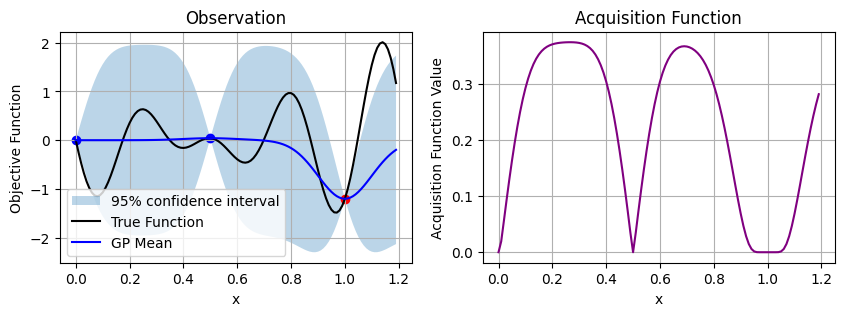

In [81]:
# Sample initial points and their corresponding function values

sample_x_list = np.array([0.0, 0.5, 1.0])
sample_y_list = simple_test_objective(sample_x_list)

# Initialize and fit the custom GP model using the sample data
gp_custom = GaussianProcess(kernel=rbf_kernel)
gp_custom.fit(sample_x_list.reshape(-1, 1), sample_y_list)

# Define sample points for plotting
sample_points = np.arange(0, 1.2, 0.01)

# Define our best observed value so far
y_best = np.max(sample_y_list)
print(y_best)

# Compute the EI values for each point in the sample_points using the custom GP model
ei_values = expected_improvement(
    X=sample_points.reshape(-1, 1),  # Points where we evaluate EI
    gp=gp_custom,
    y_best=y_best,
    xi=0.01
)

# Plot the GP, true function, and EI acquisition function
plot_gp_and_acquisition(
    true_function=simple_test_objective,
    gp_model=gp_custom,
    sample_x_list=sample_x_list,
    sample_y_list=sample_y_list,
    sample_points=sample_points,
    acquisition_values=ei_values,
    acq_x_range=sample_points
)

### 2.6 Putting everything together [IMPORTANT]

Psuedo code for Bayesian optimization

1. **Initialize and Sample Initial Points**
    - Determine the problem dimensionality based on `bounds`.
    - Randomly sample `num_random_init` points within `bounds` as initial observations.
    - Evaluate the `target_function` at each initial point to get corresponding output values.

2. **Initialize Gaussian Process Model**
    - Create and fit a Gaussian Process (GP) model to the initial observed data using the specified `kernel` and `mean_func`.

3. **Optimization Loop** (for each step in `num_steps`):
    - **Generate Candidate Points** within the specified bounds to evaluate potential next points.
    
    - **Compute Acquisition Function** values for each candidate point using the GP model. This guides the search toward regions that maximize improvement over the best-observed value.
    
    - **Select Next Point** as the candidate with the highest acquisition function value and evaluate `target_function` at this point.

    - **Update Observations and GP Model** by adding the new point and outcome, then refitting the GP model on the updated dataset.

4. **Return Results**
    - After completing all steps, return the observed points, their function values, and the final GP model.


In [82]:
def bayesian_optimization(target_function, bounds, num_steps, num_random_init=5, kernel=rbf_kernel, acquisition_func="EI", xi=0.01, kappa=2.0, mean_func=lambda x: 0, plot_progress=True):
    is_1d = len(bounds) == 1
    num_dims = 1 if is_1d else len(bounds)
    
    # Generate initial random samples within the specified bounds
    X_observed = np.random.uniform(
        [b[0] for b in bounds], [b[1] for b in bounds], size=(num_random_init, num_dims)
    )
    y_observed = np.array([target_function(x if not is_1d else x[0]) for x in X_observed]).flatten()

    # Initialize the GP model with the random samples and custom mean function
    gp = GaussianProcess(kernel=kernel, mean_func=mean_func)
    gp.fit(X_observed, y_observed)

    # Begin optimization loop
    for step in range(num_steps):
        # Generate a grid within the bounds
        grids = [np.linspace(b[0], b[1], 50) for b in bounds]  # Adjust grid density as needed
        X_grid = np.array(np.meshgrid(*grids)).T.reshape(-1, num_dims)

        # Select acquisition function
        if acquisition_func == "EI":
            af_values = expected_improvement(X_grid, gp, np.max(y_observed), xi=xi)
        elif acquisition_func == "UCB":
            af_values = upper_confidence_bound(X_grid, gp, kappa=kappa)
        elif acquisition_func == "PI":
            af_values = probability_of_improvement(X_grid, gp, np.max(y_observed), xi=xi)
        else:
            raise ValueError("Unknown acquisition function. Choose from 'EI', 'UCB', 'PI'.")

        # Select next point as the arg max of the acquisition function
        next_x = X_grid[np.argmax(af_values)].reshape(1, -1)
        next_y = target_function(next_x.flatten() if not is_1d else next_x[0, 0])

        # Add the new observation
        X_observed = np.vstack((X_observed, next_x))
        y_observed = np.append(y_observed, next_y)

        # Update the GP model with the new data
        gp.fit(X_observed, y_observed)

        # Print step results
        print(f"Step {step + 1} ({acquisition_func}): x={next_x.flatten() if not is_1d else next_x[0, 0]}, y={next_y}")
        
        # Plot results based on dimensionality, if plot_progress is True
        if plot_progress:
            if is_1d:
                plot_gp_and_acquisition(
                    true_function=target_function,
                    gp_model=gp,
                    sample_x_list=X_observed.flatten(),
                    sample_y_list=y_observed,
                    sample_points=X_grid.flatten(),
                    acquisition_values=af_values,
                    acq_x_range=X_grid.flatten()
                )
            else:
                plot_2d_gp_and_acquisition(
                    true_function=target_function,
                    gp_model=gp,
                    sample_x_list=X_observed,
                    sample_y_list=y_observed,
                    bounds=bounds,
                    acquisition_function=expected_improvement,
                    xi=xi
                )

    return X_observed, y_observed, gp


Step 1 (EI): x=0.8816326530612244, y=-0.2000853992216035


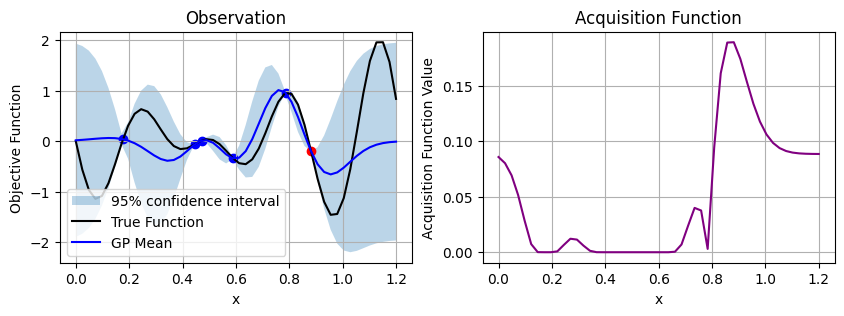

Step 2 (EI): x=0.7346938775510203, y=0.4918003978793881


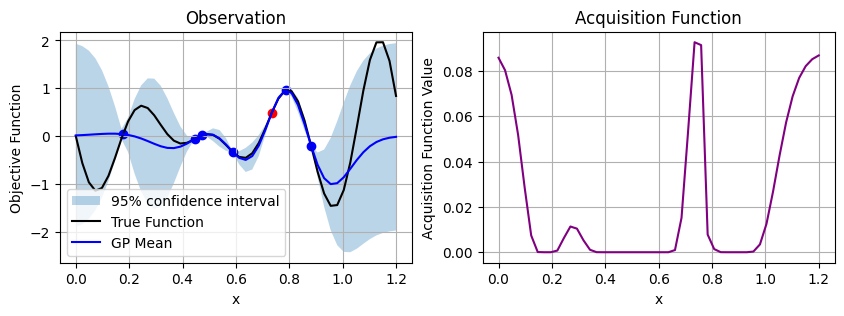

Step 3 (EI): x=1.2, y=0.8387510816408755


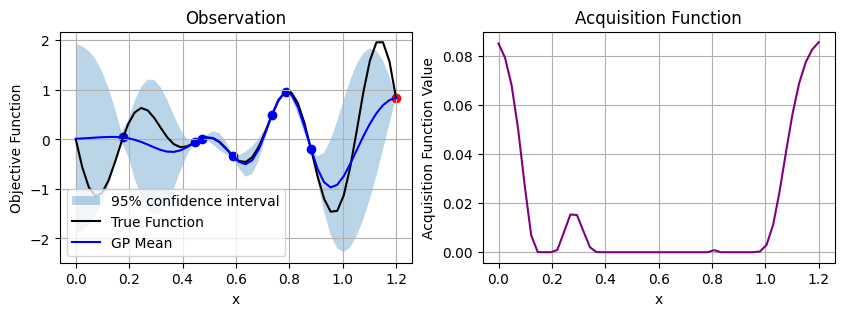

Step 4 (EI): x=1.126530612244898, y=1.9594420061565105


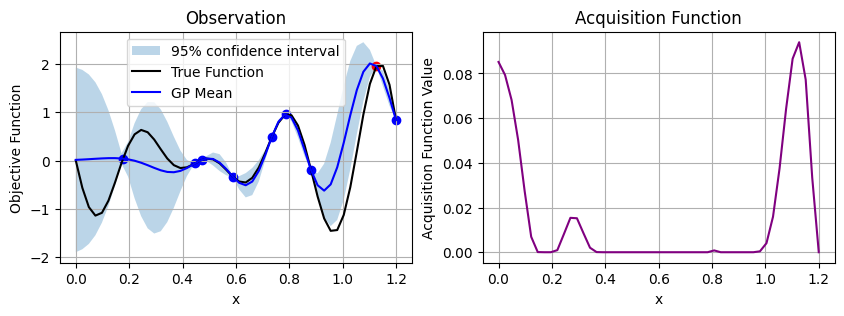

Step 5 (EI): x=1.1020408163265305, y=1.5906109102506918


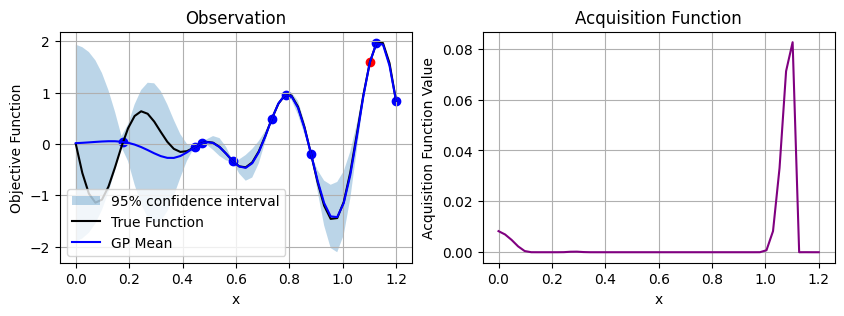

In [83]:
# Run Bayesian Optimization with bounds [0, 1.2], 5 random initial samples, and 10 total steps
X_observed, y_observed, gp_model = bayesian_optimization(
        target_function=simple_test_objective,
        bounds=simple_bounds_1d,
        num_steps=5,  # Reduced steps for quick comparison
        num_random_init=5,
        acquisition_func="EI",
        xi=0.01,
        kappa=2.0
    )

## 3. More kernels, acquisition functions, and 2D functions

### 3.1 More kernels 

[IMPORTANT for MATERN KERNEL, PEDIODIC KERNEL; DON'T NEED TO MEMERIZE THE MATH, BUT YOU NEED TO KNOW THE CONCEPTUAL DIFFERENCES]

#### 0. Length Scale: A Key Parameter in most Kernel Functions

The **length scale** parameter, denoted as $\text{length\_scale}$, controls the smoothness of the function generated by the Gaussian Process. It dictates how quickly the correlation between points decreases as they move further apart.

- **Small** $\text{length\_scale}$ values cause the model to vary rapidly, fitting closely to nearby points and capturing fine-grained patterns.
- **Large** $\text{length\_scale}$ values lead to smoother functions, where points far apart still maintain high correlation.

This parameter affects each kernel's behavior, influencing the resulting function's flexibility and generalization.

---

#### 1. Matern Kernel (YOUR TASK 1, 3P) 
<a id="TASK1"></a>


The Matérn kernel is a popular choice in Gaussian Process modeling because it provides a tunable smoothness parameter, $\nu$, which controls the smoothness of the resulting function. The general form of the Matérn kernel is:

$$
K(X_i, X_j) = \sigma_f^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \frac{\sqrt{2\nu} \cdot d_{ij}}{\text{length\_scale}} \right)^\nu K_\nu \left( \frac{\sqrt{2\nu} \cdot d_{ij}}{\text{length\_scale}} \right),
$$

where:
- $ d_{ij} $ is the Euclidean distance between points $X_i$ and $X_j$,
- $\sigma_f^2$ is the output variance, controlling the amplitude of the kernel,
- $\text{length\_scale}$ determines how quickly correlations decay with distance,
- $\Gamma(\nu)$ is the Gamma function,
- $K_\nu$ is the modified Bessel function of the second kind.

For specific values of $\nu = 0.5, 1.5,$ and $2.5$, the kernel function simplifies to more practical forms:

Let $d_{ij}$ be the Euclidean distance between points $X_i$ and $X_j$:
$$
d_{ij} = \sqrt{\sum_{k=1}^{n} (X_{i} - X_{j})^2}.
$$

The Matérn kernel is given by:

- **When** $\nu = 0.5$ (exponential kernel):
  $$
  K(X_i, X_j) = \sigma_f^2 \exp\left(-\frac{d_{ij}}{\text{length\_scale}}\right)
  $$

- **When** $\nu = 1.5$:
  $$
  K(X_i, X_j) = \sigma_f^2 \left(1 + \frac{\sqrt{3} \cdot d_{ij}}{\text{length\_scale}}\right) \exp\left(-\frac{\sqrt{3} \cdot d_{ij}}{\text{length\_scale}}\right)
  $$

- **When** $\nu = 2.5$:
  $$
  K(X_i, X_j) = \sigma_f^2 \left(1 + \frac{\sqrt{5} \cdot d_{ij}}{\text{length\_scale}} + \frac{5 \cdot d_{ij}^2}{3 \cdot \text{length\_scale}^2}\right) \exp\left(-\frac{\sqrt{5} \cdot d_{ij}}{\text{length\_scale}}\right)
$$

where $\sigma_f^2$ is the output variance, controlling the amplitude of the kernel.

**What is the key difference between Matern Kernel and RBF Kernel?** 

Matern Kernel has a smoothness parameter for the differentiability of the function while RBF Kernel is infinitely differentiable/smooth (https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html)

---

#### 2. Periodic Kernel

The periodic kernel is useful for capturing repeating patterns and is defined by the following expression:

$$ K(X_i, X_j) = \sigma_f^2 \exp\left(-\frac{2 \sin^2\left(\frac{\pi d_{ij}}{\text{period}}\right)}{\text{length\_scale}^2}\right) $$

where:
- $ d_{ij} = \| X_i - X_j \| $ is the Euclidean distance.
- $ \text{period} $ defines the distance between repetitions of the pattern.
- $ \text{length\_scale} $ controls the smoothness of the periodicity.

**What is the key difference between Periodic Kernel and RBF Kernel?**

The periodic kernel is periodic while the RBF kernel is not.

---

#### 3. Rational Quadratic Kernel

The Rational Quadratic kernel is equivalent to a weighted sum of RBF kernels with varying length scales and is defined as:

$$ K(X_i, X_j) = \sigma_f^2 \left(1 + \frac{d_{ij}^2}{2 \alpha \cdot \text{length\_scale}^2}\right)^{-\alpha} $$

where:
- $ d_{ij} = \| X_i - X_j \|^2 $ is the squared Euclidean distance.
- $ \alpha $ is a parameter that controls the relative weighting of different length scales.
- $ \sigma_f^2 $ is the output variance.


In [84]:
# Define additional kernel functions

# Matern Kernel
def matern_kernel(X1, X2, length_scale=1.0, nu=2.5, sigma_f=1.0):
    """
    Matern kernel with parameter nu (1.5 or 2.5 are typical values).
    """
    dists = np.sqrt(np.sum((X1[:, None] - X2[None, :])**2, axis=2))
    sqrt3 = np.sqrt(3)
    sqrt5 = np.sqrt(5)
    if nu == 0.5:
        K = sigma_f**2 * np.exp(-dists / length_scale)  ## THIS LINE IS CORRECT, DO NOT CHANGE!
    elif nu == 1.5:
        K = sigma_f**2 * (1 + sqrt3 * dists / length_scale) * np.exp(-sqrt3 * dists / length_scale)  ## CORRECT THIS ONE
    elif nu == 2.5:
        K = sigma_f**2 * (1 + sqrt5 * dists / length_scale + 5 * dists**2 / (3 * length_scale**2)) * np.exp(-sqrt5 * dists / length_scale)  ## CORRECT THIS ONE
    return K

# Periodic Kernel
def periodic_kernel(X1, X2, length_scale=1.0, period=1.0, sigma_f=1.0):
    """
    Periodic kernel for capturing repeating patterns.
    """
    dists = np.sqrt(np.sum((X1[:, None] - X2[None, :])**2, axis=2))
    return sigma_f**2 * np.exp(-2 * (np.sin(np.pi * dists / period)**2) / length_scale**2)

# Rational Quadratic Kernel
def rational_quadratic_kernel(X1, X2, length_scale=1.0, alpha=1.0, sigma_f=1.0):
    """
    Rational Quadratic kernel, similar to a mixture of RBF kernels with different length scales.
    """
    dists = np.sum((X1[:, None] - X2[None, :])**2, axis=2)
    return sigma_f**2 * (1 + dists / (2 * alpha * length_scale**2))**(-alpha)


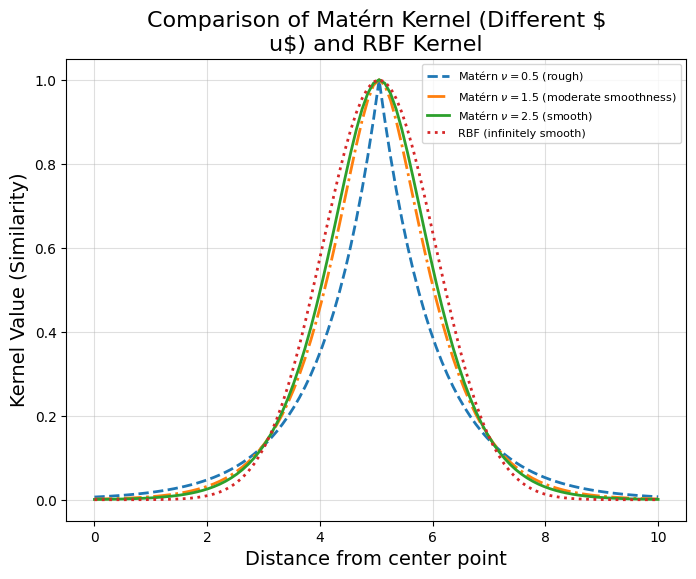

In [85]:
## Visualize the difference between RBF and Matern
# Generate sample points

X = np.linspace(0, 10, 100).reshape(-1, 1)
# Compute kernel values using the provided functions
K_matern_05 = matern_kernel(X, X, length_scale=1.0, nu=0.5)
K_matern_15 = matern_kernel(X, X, length_scale=1.0, nu=1.5)
K_matern_25 = matern_kernel(X, X, length_scale=1.0, nu=2.5)
K_rbf = rbf_kernel(X, X, length_scale=1.0)

# Plot the kernels
plt.figure(figsize=(8, 6))
plt.plot(X, K_matern_05[:, 50], label=r'Matérn $\nu=0.5$ (rough)', linestyle='--', linewidth=2)
plt.plot(X, K_matern_15[:, 50], label=r'Matérn $\nu=1.5$ (moderate smoothness)', linestyle='-.', linewidth=2)
plt.plot(X, K_matern_25[:, 50], label=r'Matérn $\nu=2.5$ (smooth)', linestyle='-', linewidth=2)
plt.plot(X, K_rbf[:, 50], label='RBF (infinitely smooth)', linestyle=':', linewidth=2)

# Add labels, legend, and grid
plt.title('Comparison of Matérn Kernel (Different $\nu$) and RBF Kernel', fontsize=16)
plt.xlabel('Distance from center point', fontsize=14)
plt.ylabel('Kernel Value (Similarity)', fontsize=14)
plt.legend(fontsize=8)
plt.grid(alpha=0.4)
plt.show()


Running Bayesian Optimization with RBF Kernel...

Step 1 (EI): x=1.1755102040816325, y=1.5720505360632906


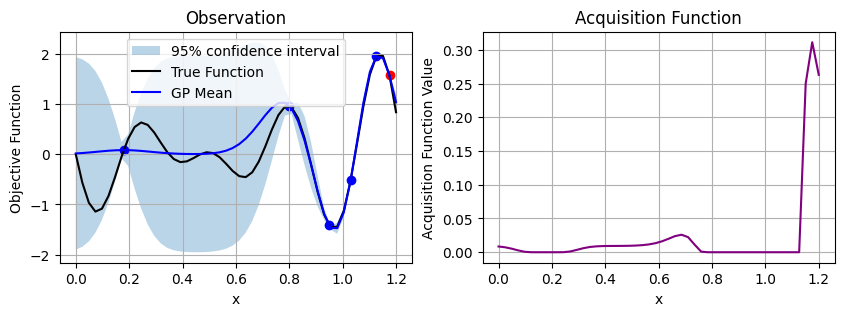

Step 2 (EI): x=0.6612244897959183, y=-0.35985313854729317


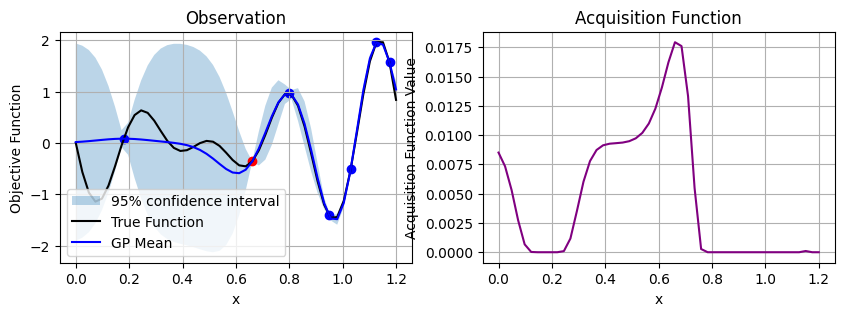

Step 3 (EI): x=0.0, y=-0.0


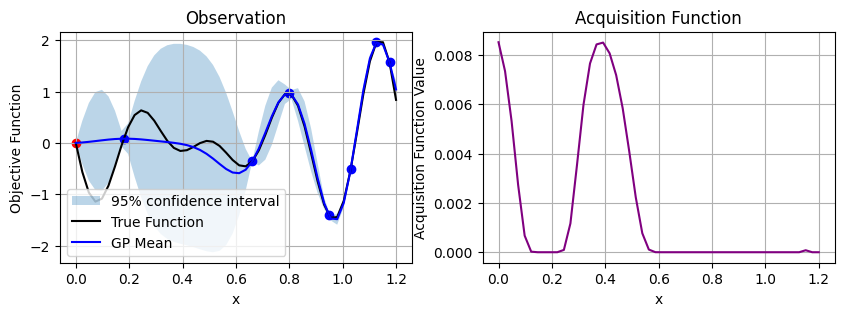

Step 4 (EI): x=0.39183673469387753, y=-0.15625525883261357


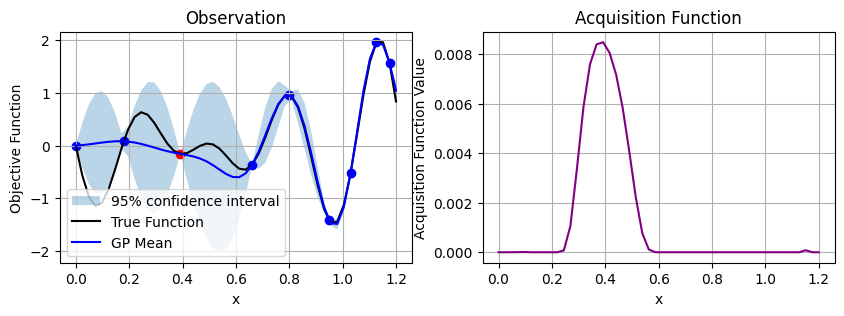

Step 5 (EI): x=0.5142857142857142, y=0.023835867471826255


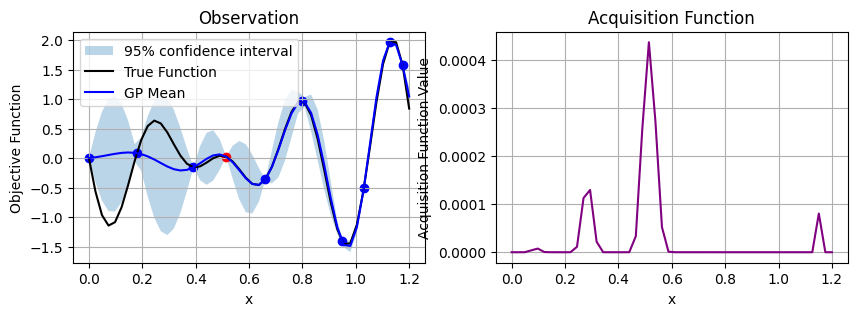


Running Bayesian Optimization with Matern Kernel...

Step 1 (EI): x=1.0285714285714285, y=-0.5546410376763447


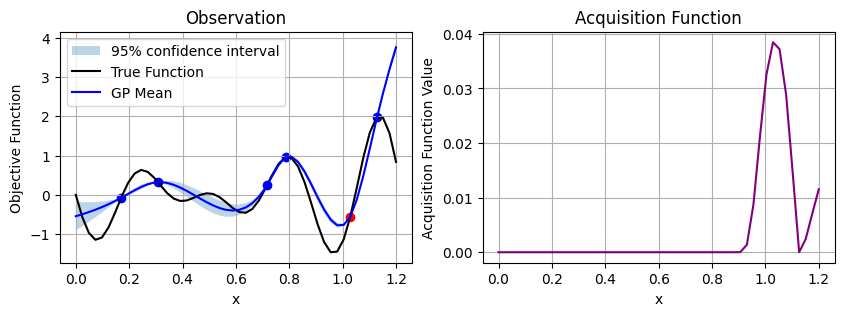

Step 2 (EI): x=1.2, y=0.8387510816408755


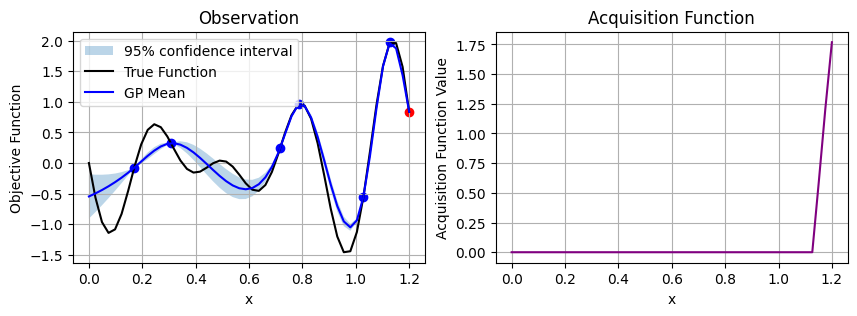

Step 3 (EI): x=1.1510204081632653, y=1.9625647191627857


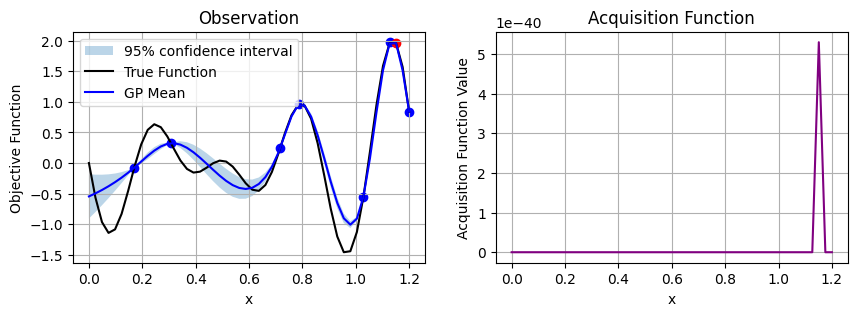

Step 4 (EI): x=0.0, y=-0.0


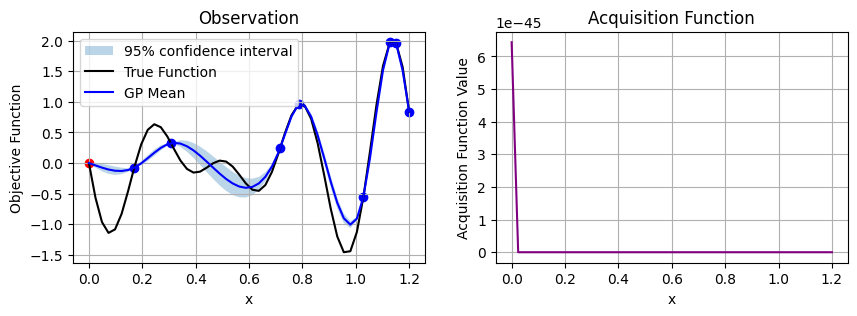

Step 5 (EI): x=0.46530612244897956, y=-0.0035390148979869336


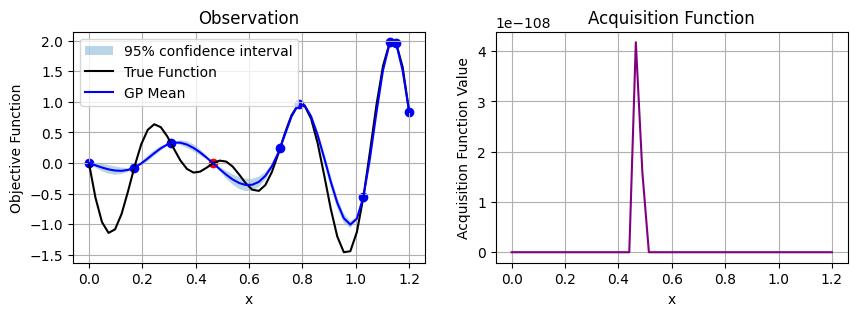


Running Bayesian Optimization with Periodic Kernel...

Step 1 (EI): x=0.7346938775510203, y=0.4918003978793881


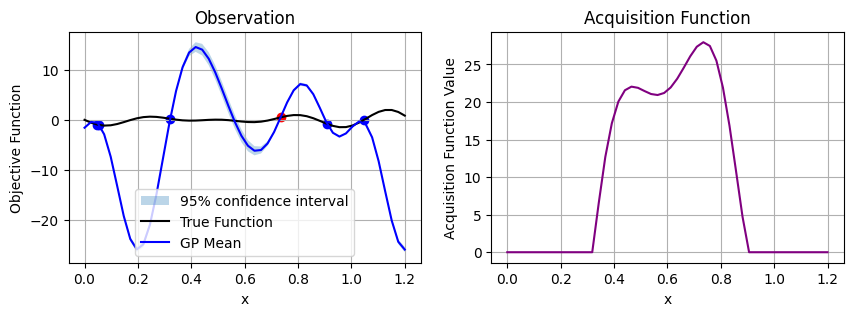

Step 2 (EI): x=0.4163265306122449, y=-0.14133398226952146


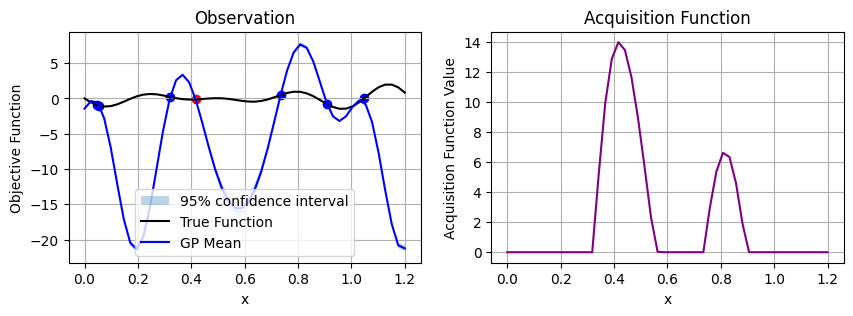

Step 3 (EI): x=0.8081632653061224, y=0.9396740764172679


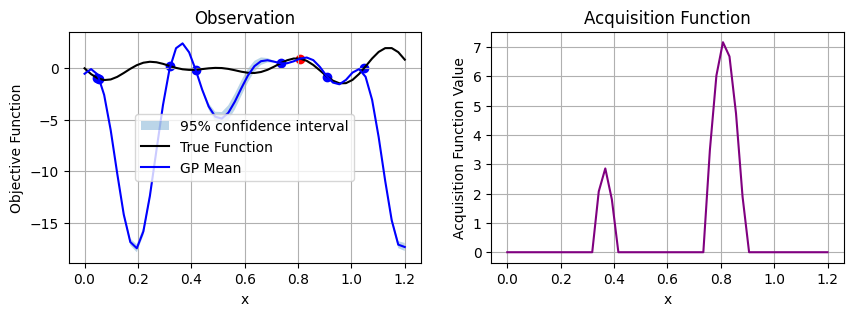

Step 4 (EI): x=0.36734693877551017, y=-0.09628646912504364


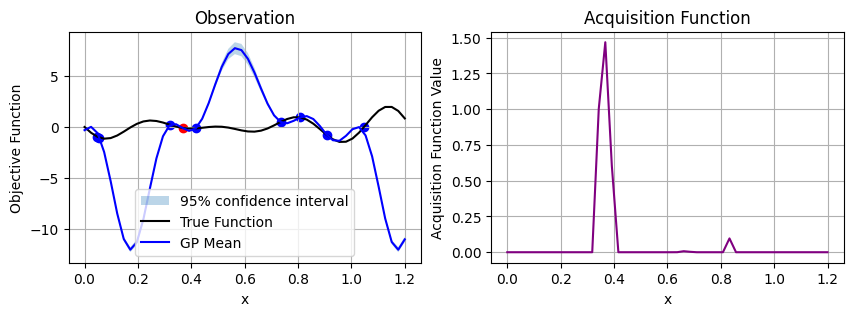

Step 5 (EI): x=0.563265306122449, y=-0.18977579676313905


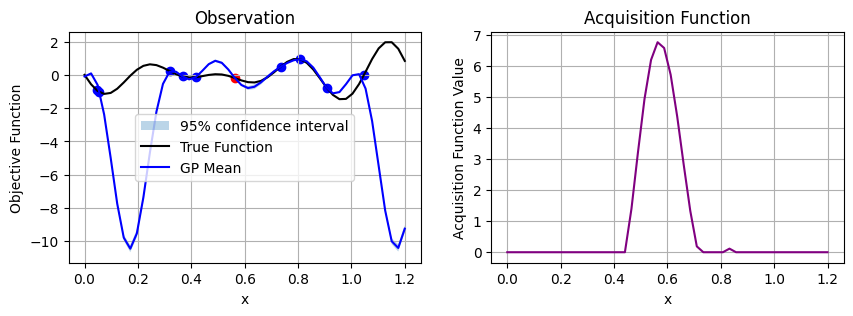


Running Bayesian Optimization with Rational Quadratic Kernel...

Step 1 (EI): x=0.0, y=-0.0


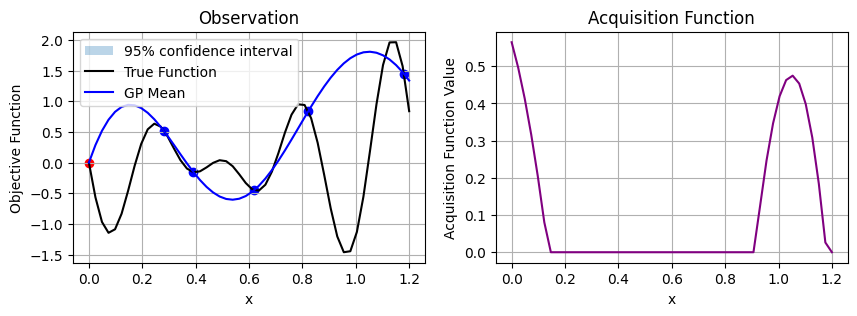

Step 2 (EI): x=1.0530612244897959, y=0.18533046571331155


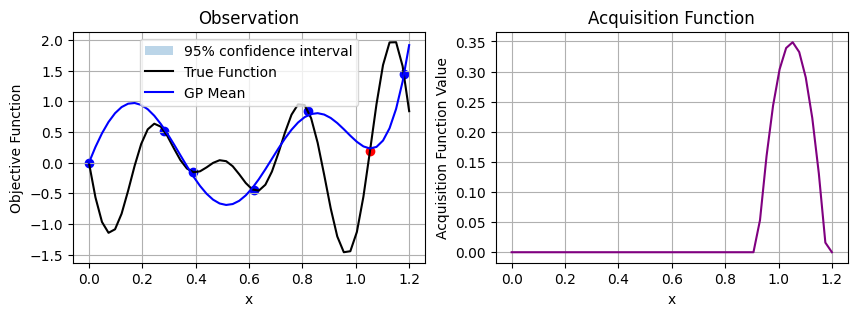

Step 3 (EI): x=1.2, y=0.8387510816408755


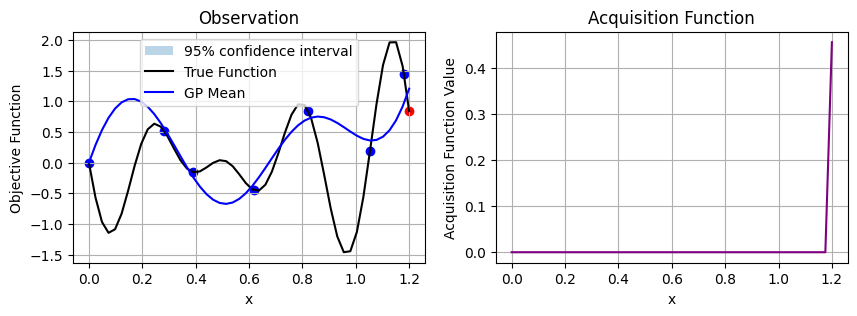

Step 4 (EI): x=0.0, y=-0.0


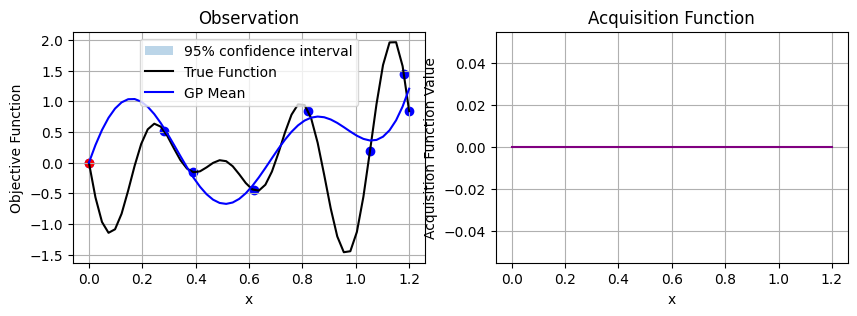

Step 5 (EI): x=0.0, y=-0.0


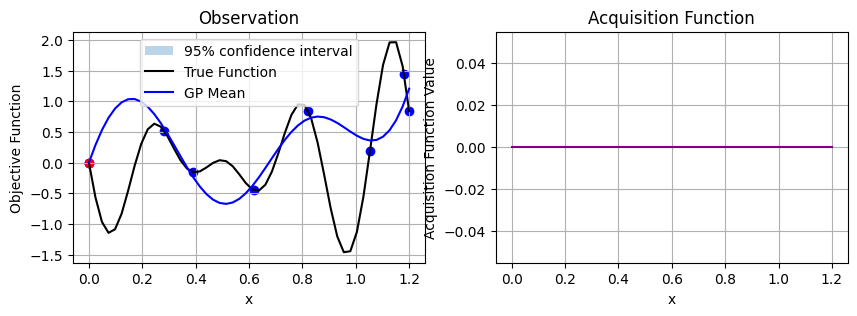

In [86]:
# Define a function to run BO with different kernels
def run_bo_with_kernel(kernel, kernel_name):
    print(f"\nRunning Bayesian Optimization with {kernel_name}...\n")
    X_observed, y_observed, gp_model = bayesian_optimization(
        target_function=simple_test_objective,
        bounds=simple_bounds_1d,
        num_steps=5,  # Reduced steps for comparison
        num_random_init=5,
        kernel=kernel,  # Pass the specified kernel
        xi=0.01
    )
    return X_observed, y_observed, gp_model

# Run Bayesian Optimization with each kernel
results = {}
kernels = {
    "RBF Kernel": rbf_kernel,
    "Matern Kernel": lambda X1, X2: matern_kernel(X1, X2, nu=1.5),
    "Periodic Kernel": periodic_kernel,
    "Rational Quadratic Kernel": rational_quadratic_kernel
}

# Test each kernel
for kernel_name, kernel in kernels.items():
    results[kernel_name] = run_bo_with_kernel(kernel, kernel_name)

### 3.2 More acquisition functions

[IMPORTANT; NO NEED TO MEMERIZE THE MATH, BUT NEED TO KNOW THE CONCEPTUAL DIFFERENCE]

#### 1. Upper Confidence Bound (UCB) Acquisition Function

The Upper Confidence Bound (UCB) acquisition function encourages exploration by considering both the predicted mean and uncertainty in the model. It is defined as:

$$
\text{UCB}(X) = \mu(X) + \kappa \cdot \sigma(X)
$$

where:
- $ X $ represents the candidate points to evaluate.
- $ \mu(X) $ is the **predicted mean** at $ X $, which reflects the Gaussian Process's best guess at the objective function value.
- $ \sigma(X) $ is the **predicted standard deviation** at $ X $, representing the uncertainty in the prediction.
- $ \kappa $ is a trade-off parameter that controls the balance between exploration and exploitation:
  - A **higher** $ \kappa $ value places more emphasis on $ \sigma(X) $, encouraging exploration by prioritizing points with high uncertainty.
  - A **lower** $ \kappa $ value places more emphasis on $ \mu(X) $, favoring points expected to have high values, thus focusing on exploitation.

The UCB acquisition function is particularly useful in high-dimensional spaces because it provides a simple balance between exploring unknown areas and exploiting promising ones.

---

#### 2. Probability of Improvement (PI) Acquisition Function

The Probability of Improvement (PI) acquisition function selects points with a high probability of outperforming the best observed value. The PI function is defined as:

$$
\text{PI}(X) = \Phi\left( \frac{\mu(X) - y_{\text{best}} - \xi}{\sigma(X)} \right)
$$

where:
- $ \Phi $ represents the **cumulative distribution function** (CDF) of the standard normal distribution.
- $ X $ is the candidate point to evaluate.
- $ \mu(X) $ is the **predicted mean** at $ X $.
- $ y_{\text{best}} $ is the **best observed value** so far, representing the highest (or lowest in minimization) sampled objective function value.
- $ \sigma(X) $ is the **predicted standard deviation** at $ X $.
- $ \xi $ is an **exploration parameter** that encourages more exploration when set to a positive value:
  - A **higher** $ \xi $ allows the acquisition function to consider more diverse points, increasing exploration.
  - A **lower** $ \xi $ makes the acquisition function more exploitative, focusing on points with high expected improvements.

The PI function evaluates the probability that the sample at $ X $ will improve upon $ y_{\text{best}} $ by at least $ \xi $. It is useful when the goal is to quickly locate regions with high values rather than fully exploring the entire space.


In [87]:
# Upper Confidence Bound (UCB) Acquisition Function

def upper_confidence_bound(X, gp, kappa=2.0):
    """
    Compute the Upper Confidence Bound (UCB) acquisition function values.
    Parameters:
    - X : array-like, shape (n_samples, n_features)
        The input samples where the acquisition function is evaluated.
    - gp : GaussianProcess object
        A fitted Gaussian Process model that provides predictions.
    - kappa : float
        Controls the trade-off between exploration and exploitation (higher values = more exploration).
        
    Returns:
    - ucb : array-like, shape (n_samples,)
        Upper Confidence Bound values for each sample in X.
    """

    mu, std = gp.predict(X)
    ucb = mu + kappa * std
    return ucb

# Probability of Improvement (PI) Acquisition Function
def probability_of_improvement(X, gp, y_best, xi=0.01):
    """
    Compute the Probability of Improvement (PI) acquisition function values.

    Parameters:
    - X : array-like, shape (n_samples, n_features)
        The input samples where the acquisition function is evaluated.
    - gp : GaussianProcess object
        A fitted Gaussian Process model that provides predictions.
    - y_best : float
        The best observed objective function value.
    - xi : float
        Exploration parameter, encouraging more exploration if higher.

    Returns:
    - pi : array-like, shape (n_samples,)
        Probability of Improvement values for each sample in X.
    """
    mu, std = gp.predict(X)
    Z = (mu - y_best - xi) / std
    pi = norm.cdf(Z)
    return pi



Running Bayesian Optimization with EI acquisition function...

Step 1 (EI): x=0.6122448979591837, y=-0.43660002898659694


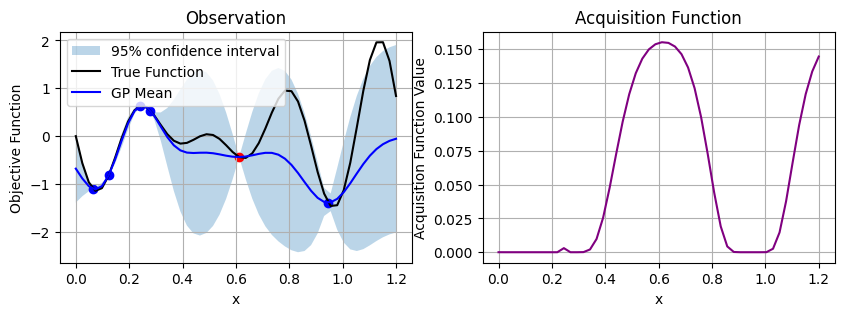

Step 2 (EI): x=1.2, y=0.8387510816408755


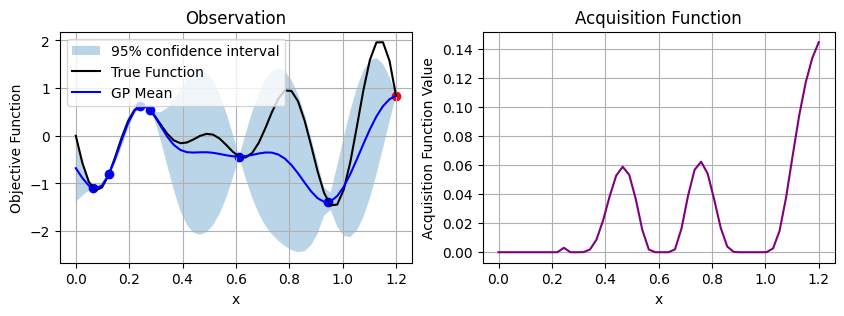

Step 3 (EI): x=1.1510204081632653, y=1.9625647191627857


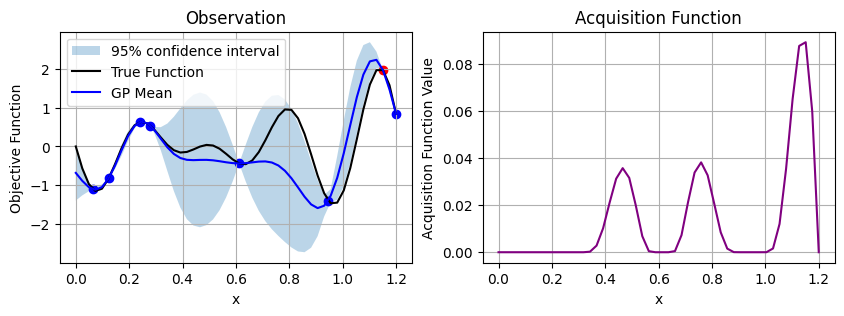

Step 4 (EI): x=1.126530612244898, y=1.9594420061565105


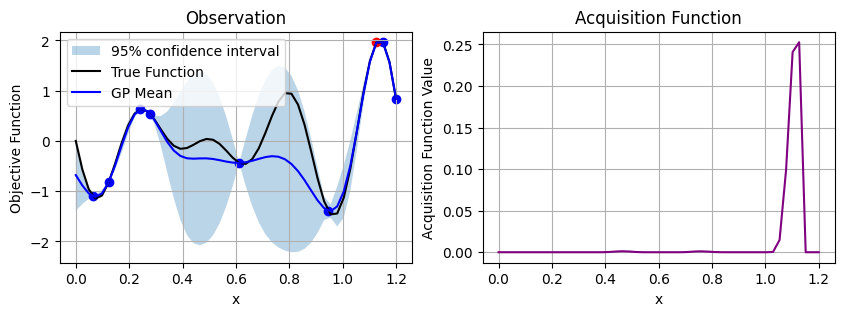

Step 5 (EI): x=0.7591836734693878, y=0.7816557602078233


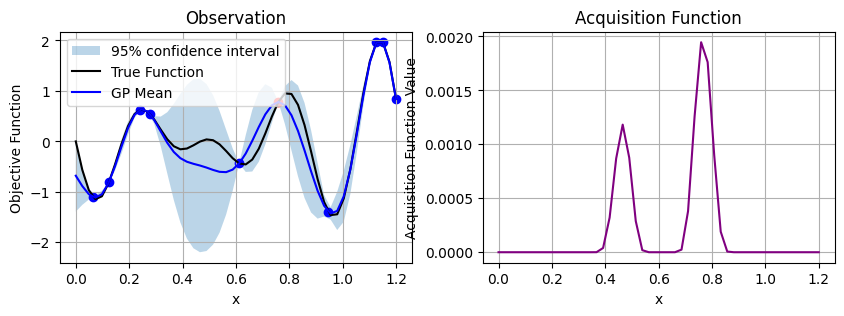


Running Bayesian Optimization with UCB acquisition function...

Step 1 (UCB): x=0.0, y=-0.0


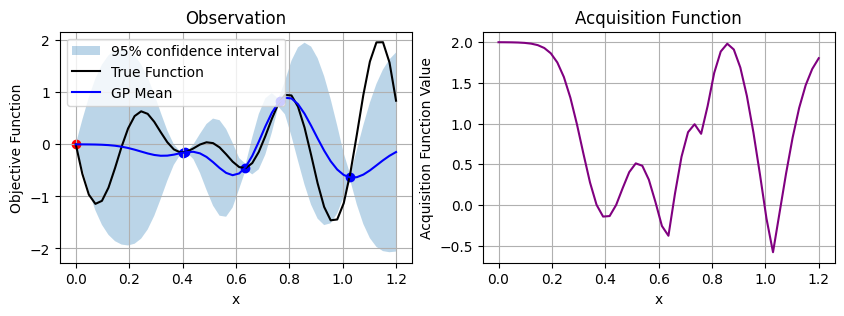

Step 2 (UCB): x=0.8571428571428571, y=0.3230461708065229


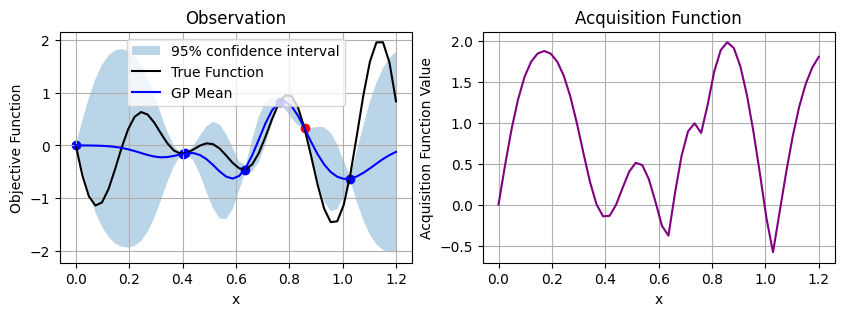

Step 3 (UCB): x=0.17142857142857143, y=-0.04946651699980042


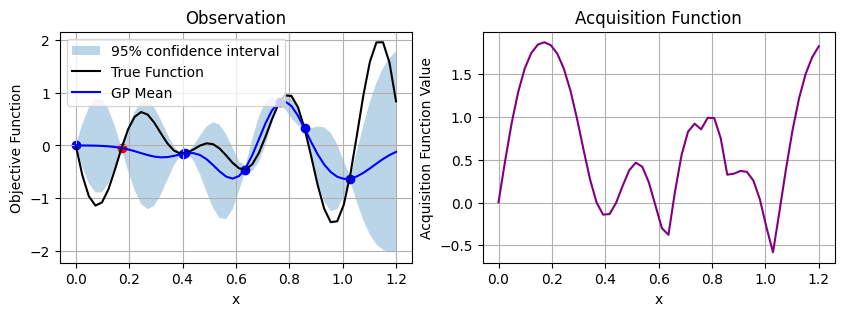

Step 4 (UCB): x=1.2, y=0.8387510816408755


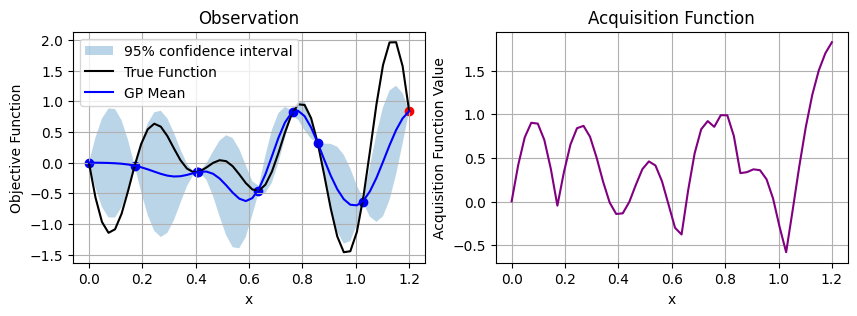

Step 5 (UCB): x=1.1510204081632653, y=1.9625647191627857


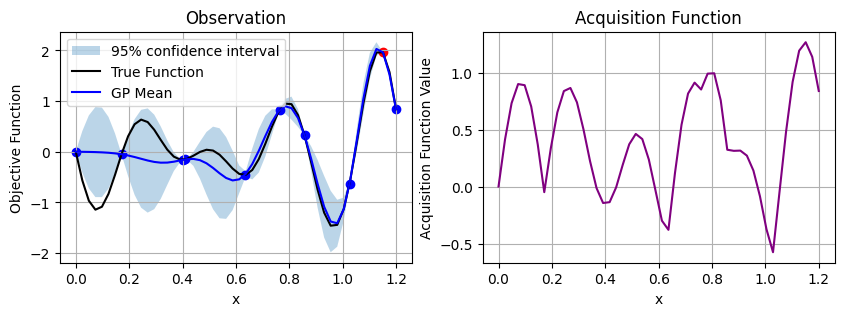


Running Bayesian Optimization with PI acquisition function...

Step 1 (PI): x=0.2693877551020408, y=0.5863243655079161


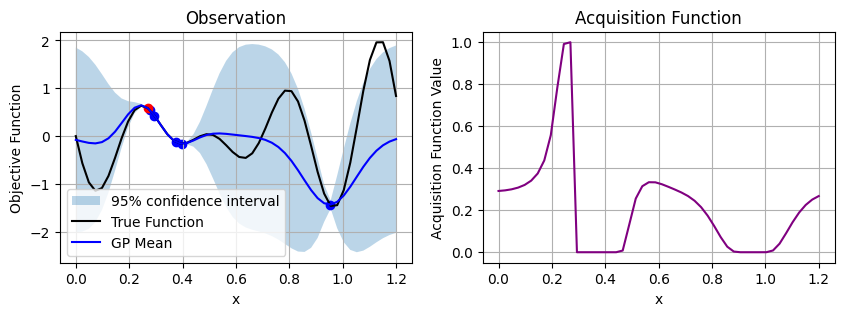

Step 2 (PI): x=0.24489795918367346, y=0.6347547191551849


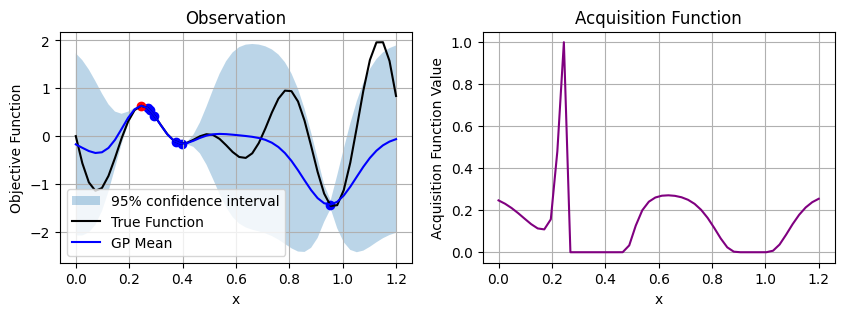

Step 3 (PI): x=0.636734693877551, y=-0.4558825567263954


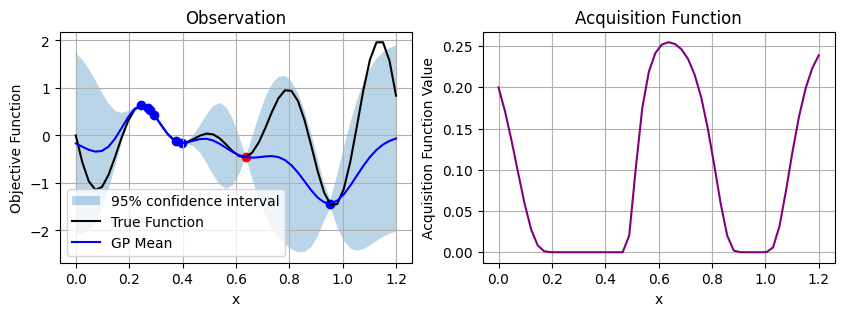

Step 4 (PI): x=1.2, y=0.8387510816408755


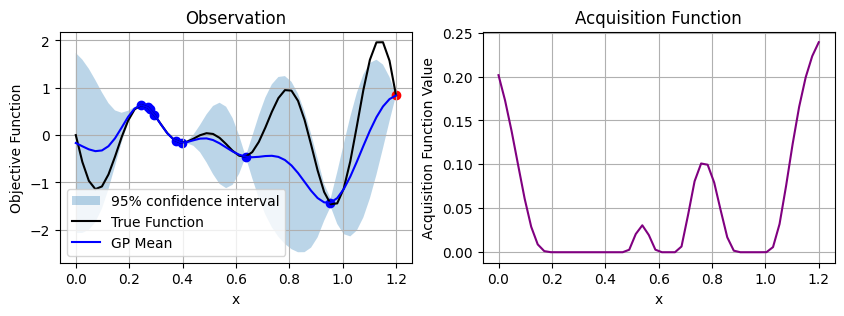

Step 5 (PI): x=1.1755102040816325, y=1.5720505360632906


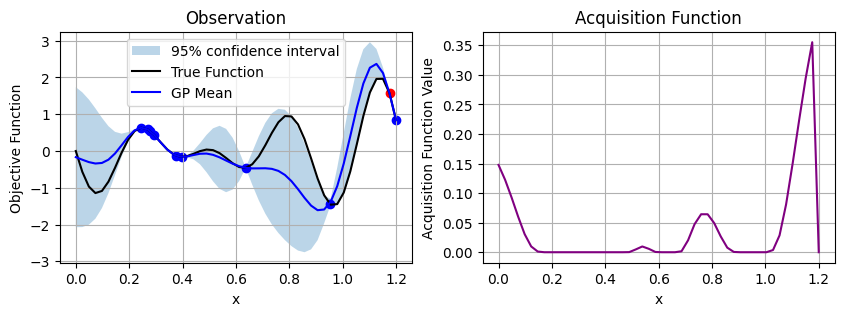

In [88]:
# Run Bayesian Optimization with different acquisition functions
acquisition_functions = ["EI", "UCB", "PI"]
results_af = {}

for af in acquisition_functions:
    print(f"\nRunning Bayesian Optimization with {af} acquisition function...\n")
    results_af[af] = bayesian_optimization(
        target_function=simple_test_objective,
        bounds=simple_bounds_1d,
        num_steps=5,  # Reduced steps for quick comparison
        num_random_init=5,
        acquisition_func=af,
        xi=0.01,
        kappa=2.0
    )

### 3.3 Bayesian optimization handling multi-dimensional input

We now move on to a more challenging scenario: the function has 2D input.

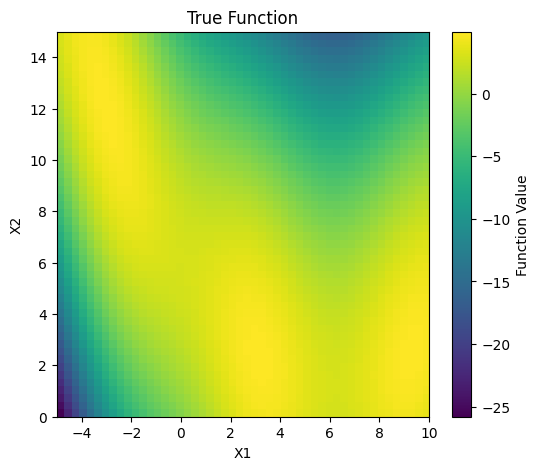

Maximum Branin function value: 4.9596928727002405
At point: [9.39393939 2.42424242]


In [89]:
# Branin is one of the most common function for testing optimization methods

bounds_branin = [(-5, 10), (0, 15)]
def branin(x):
    """
    Parameters:
    - x : array-like, [x1, x2], where x1 and x2 are the normalized input coordinates in [0, 1]^2.
    
    Returns:
    - value : float, the function value at the specified coordinates in the typical Branin range.
    """
    x1, x2 = x
    # Branin function calculation
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    return 5 - (a * (x2 - b * x1**2 + c * x1 - r)**2 + s * (1 - t) * np.cos(x1) + s) / 10

plot_true_function(branin, bounds_branin, title="True Function")

# Define the grid resolution
grid_resolution = 100  # Adjust for finer or coarser grid

# Define the grid over the bounds
x1_vals = np.linspace(bounds_branin[0][0], bounds_branin[0][1], grid_resolution)
x2_vals = np.linspace(bounds_branin[1][0], bounds_branin[1][1], grid_resolution)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid_points = np.c_[X1.ravel(), X2.ravel()]

# Evaluate the Branin function on the grid
branin_values = np.array([branin(point) for point in grid_points])

# Find the maximum Branin function value
max_branin_value = np.max(branin_values)
max_branin_point = grid_points[np.argmax(branin_values)]

print(f"Maximum Branin function value: {max_branin_value}")
print(f"At point: {max_branin_point}")

Below, we show our 2D visualization function, which will be useful for you to complete the task.

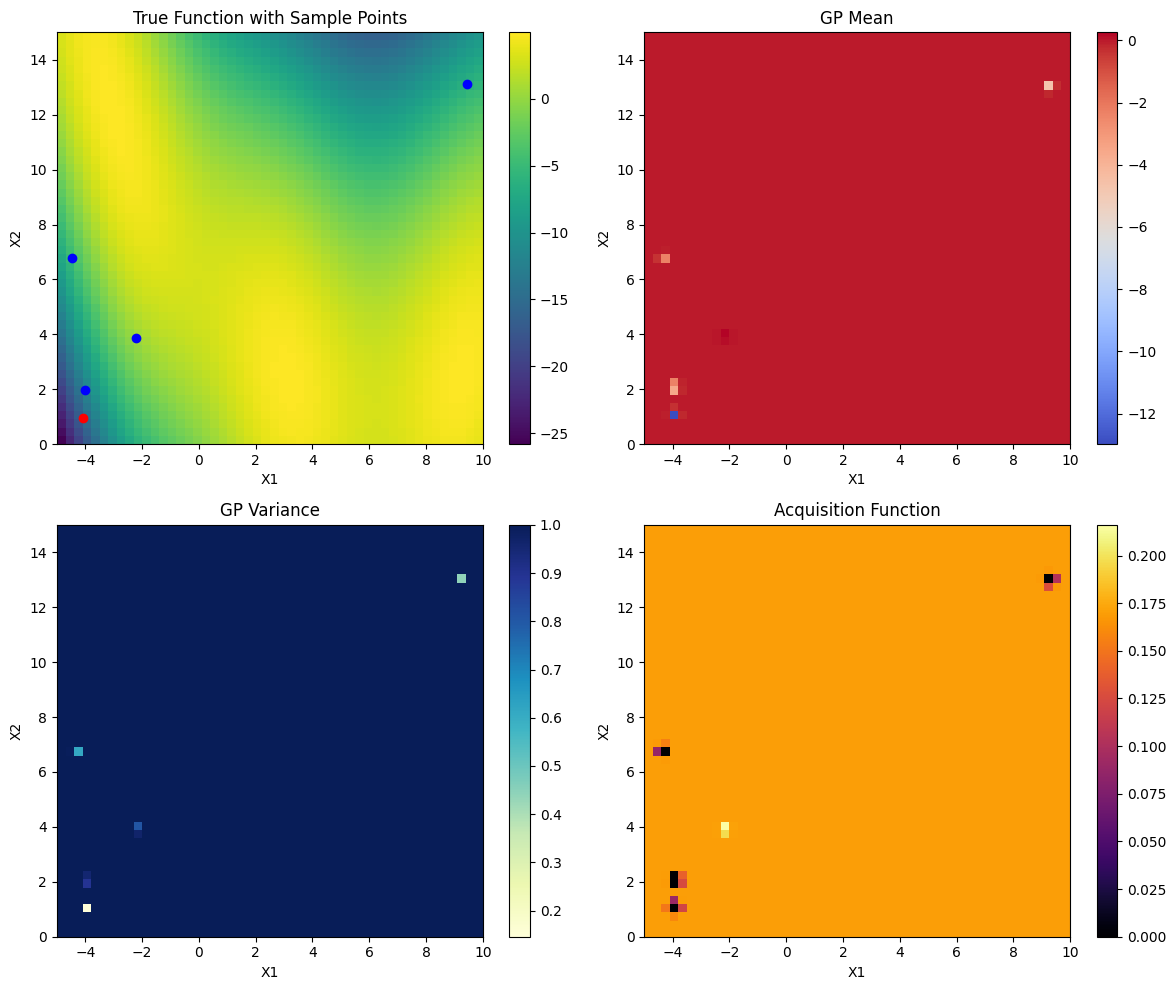

In [90]:
# Randomly sample 5 points within the bounds
sample_x_list = np.random.uniform([b[0] for b in bounds_branin], [b[1] for b in bounds_branin], (5, 2))
sample_y_list = np.array([branin(x) for x in sample_x_list])

#print(sample_x_list)
#print(sample_y_list)

# Initialize and fit GP model on sampled data
gp = GaussianProcess(kernel=rbf_kernel)
gp.fit(sample_x_list, sample_y_list)

plot_2d_gp_and_acquisition(
    true_function=branin,
    gp_model=gp,
    sample_x_list=sample_x_list,
    sample_y_list=sample_y_list,
    bounds=bounds_branin,
    acquisition_function=expected_improvement,
    xi=0.001  
)

#### YOUR TASK 2: Make Bayesian optimization ABLE TO SOLVE THE PROBLEM! (3P) [IMPORTANT]
<a id="TASK2"></a>

In the below case, you will see that Bayesian optimization does not perform very well with *3 random sampling + 5 optimization steps*.

Your goal is to tune other parameters, such as choosing a different kernel, acquisition function, mean function, etc. 

**After your modification, the mean_best_y should be at least > 4.6.**

You might need to directly change the hyperparameter of kernel or acquisition functions, if that's the case, you can copy and paste your modification in the below cell. 

In [91]:
# DO NOT CHANGE THIS CELL!!
# THIS IS AN EXAMPLE OF FAILING CASE! 

# Initialize variables for logging best y values
best_y_values = []

# Repeat Bayesian Optimization 10 times
for i in range(20):
    print(f"\nRun {i + 1} of Bayesian Optimization:")
    # Run Bayesian Optimization in 2D with specified bounds
    X_observed, y_observed, gp_model = bayesian_optimization(
        target_function=branin,
        bounds=bounds_branin,
        num_steps=5,
        num_random_init=3,
        kernel=rbf_kernel,
        acquisition_func="UCB",
        mean_func=lambda x: 0,
        xi=0.000001,
        kappa=2.0,
        plot_progress=False
    )
    
    # Log the best observed y value from this run
    best_y = np.max(y_observed) 
    best_y_values.append(best_y)
    print(f"Best y from Run {i + 1}: {best_y}")

# Output all best y values
print("\nBest y values from each run:")
for idx, best_y in enumerate(best_y_values, start=1):
    print(f"Run {idx}: Best y = {best_y}")

# Calculate and print the mean of the best y values
mean_best_y = np.mean(best_y_values)
print(f"\nMean of the best y values across 20 runs: {mean_best_y}")


Run 1 of Bayesian Optimization:
Step 1 (UCB): x=[-3.16326531 14.3877551 ], y=4.535374471882685
Step 2 (UCB): x=[-3.16326531 14.3877551 ], y=4.535374471882685
Step 3 (UCB): x=[-3.16326531 14.3877551 ], y=4.535374471882685
Step 4 (UCB): x=[-3.16326531 14.3877551 ], y=4.535374471882685
Step 5 (UCB): x=[-3.16326531 14.3877551 ], y=4.535374471882685
Best y from Run 1: 4.535374471882685

Run 2 of Bayesian Optimization:
Step 1 (UCB): x=[-4.3877551  10.10204082], y=1.42429940699778
Step 2 (UCB): x=[-4.69387755 10.10204082], y=0.15545803736440966
Step 3 (UCB): x=[-4.3877551  10.40816327], y=1.7436058317845182
Step 4 (UCB): x=[-4.69387755 10.40816327], y=0.5265820406327721
Step 5 (UCB): x=[-4.08163265 10.40816327], y=2.768415375311913
Best y from Run 2: 2.768415375311913

Run 3 of Bayesian Optimization:
Step 1 (UCB): x=[-4.69387755 13.7755102 ], y=3.371961486830489
Step 2 (UCB): x=[-4.69387755 13.7755102 ], y=3.371961486830489
Step 3 (UCB): x=[-4.69387755 13.7755102 ], y=3.371961486830489
Step 

#### Provide your answers in the below cells. 

In the first cell, you can copy the previous kernels or acquisition functions and tune their hyperparameters. 

In [92]:
## For example, you can copy periodic kernel below, and set the default period value as 2. 
## Just an example! You are encouraged to try out everything. You can create a new kernel or acquisition function, but it's not needed.
## By tuning the hyperparameters, the result can be quite promising already.

# Your specific periodic kernel
def my_periodic_kernel(X1, X2, nu=1.5,length_scale=5.0, period=2.0, sigma_f=1.0):
    """
    Periodic kernel for capturing repeating patterns.
    """
    """
    Matern kernel with parameter nu (1.5 or 2.5 are typical values).
    """
    dists = np.sqrt(np.sum((X1[:, None] - X2[None, :])**2, axis=2))
    sqrt3 = np.sqrt(3)
    sqrt5 = np.sqrt(5)
    if nu == 0.5:
        K = sigma_f**2 * np.exp(-dists / length_scale)  ## THIS LINE IS CORRECT, DO NOT CHANGE!
    elif nu == 1.5:
        K = sigma_f**2 * (1 + sqrt3 * dists / length_scale) * np.exp(-sqrt3 * dists / length_scale)  ## CORRECT THIS ONE
    elif nu == 2.5:
        K = sigma_f**2 * (1 + sqrt5 * dists / length_scale + 5 * dists**2 / (3 * length_scale**2)) * np.exp(-sqrt5 * dists / length_scale)  ## CORRECT THIS ONE
    return K

In [93]:
# In this cell, you can change the parameters that HAVE COMMENTS after. 
best_y_values = []

for i in range(20):
    print(f"\nRun {i + 1} of Bayesian Optimization:")
    # Run Bayesian Optimization in 2D with specified bounds
    X_observed, y_observed, gp_model = bayesian_optimization(
        target_function=branin,
        bounds=bounds_branin,
        num_steps=5,
        num_random_init=3,
        kernel=my_periodic_kernel,    # YOU CAN CHANGE THIS  (for example, now i use the modified kernel in the above cell)
        acquisition_func="EI",        # YOU CAN CHANGE THIS
        mean_func=lambda x: 0,        # YOU CAN CHANGE THIS
        xi=0.01,                  # YOU CAN CHANGE THIS
        kappa=2.0,                    # YOU CAN CHANGE THIS
        plot_progress=False           # Feel free to turn on the plot function to help you complete the task
    )
    
    # Log the best observed y value from this run
    best_y = np.max(y_observed) 
    best_y_values.append(best_y)
    print(f"Best y from Run {i + 1}: {best_y}")

# Output all best y values
print("\nBest y values from each run:")
for idx, best_y in enumerate(best_y_values, start=1):
    print(f"Run {idx}: Best y = {best_y}")

# Calculate and print the mean of the best y values
mean_best_y = np.mean(best_y_values)
print(f"\nMean of the best y values across 20 runs: {mean_best_y}")

if(mean_best_y > 4.6):
    print("Your optimizer has surpassed the set goal.")
else:
    print("Your optimizer HAS NOT surpassed the set goal.")


Run 1 of Bayesian Optimization:
Step 1 (EI): x=[9.3877551  5.81632653], y=3.8222592338588184
Step 2 (EI): x=[8.7755102  4.89795918], y=3.9144275874275065
Step 3 (EI): x=[9.69387755 4.59183673], y=4.572029386525914
Step 4 (EI): x=[10.          3.97959184], y=4.710304296165589
Step 5 (EI): x=[10.          3.06122449], y=4.805346419073976
Best y from Run 1: 4.805346419073976

Run 2 of Bayesian Optimization:
Step 1 (EI): x=[5.40816327 3.06122449], y=3.0272513049521486
Step 2 (EI): x=[4.18367347 3.36734694], y=4.172924350439117
Step 3 (EI): x=[3.87755102 3.06122449], y=4.545235838028397
Step 4 (EI): x=[3.57142857 2.75510204], y=4.810226212699745
Step 5 (EI): x=[3.57142857 2.44897959], y=4.849310967629977
Best y from Run 2: 4.849310967629977

Run 3 of Bayesian Optimization:
Step 1 (EI): x=[-5.          1.83673469], y=-19.83654499600559
Step 2 (EI): x=[-3.46938776  8.87755102], y=3.1458402878140967
Step 3 (EI): x=[-3.7755102   9.79591837], y=3.129798188685134
Step 4 (EI): x=[-3.16326531  9.4

#### Justification of your code

Tell me (a) what did you do, and (b) why you made such changes. 

Just spend a few sentences, no need to over-explain your decision.

#### Your answer starts from here (directly edit beloe in the cell):

For example, I hypothesize that the function is periodic, so I chose periodic kernel... 

---

## 4. Multi-objective Bayesian optimization

### 4.1 Create a second function and visualization

We simply flip Branin to create another function. 

You can compare this function to Branin, which will show you that there is not a single (x1, x2) pair that will satisfy (more technically, maximize) both Branin and reversed Branin functions.

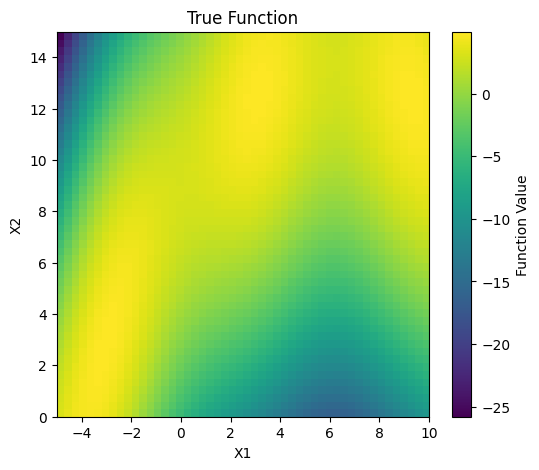

In [94]:
def reversed_branin(x):
    """
    Parameters:
    - x : array-like, [x1, x2], where x1 and x2 are the normalized input coordinates in [0, 1]^2.
    
    Returns:
    - value : float, the function value at the specified coordinates in the typical Branin range.
    """
    
    x1 = x[0]
    x2 = 15 - x[1]
        
    # Branin function calculation
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    
    return 5 - (a * (x2 - b * x1**2 + c * x1 - r)**2 + s * (1 - t) * np.cos(x1) + s) / 10
plot_true_function(reversed_branin, bounds_branin, title="True Function")

Below are just functions for visualization. No need to edit.

In [95]:
def plot_2d_observations_with_gradient(Y_observed, title="Observed 2D Objective Values", xlabel="Objective 1", ylabel="Objective 2"):
    """
    Plot the observed points in the 2D objective space with a gradient indicating observation sequence.
    
    Parameters:
    - Y_observed : array-like, shape (n_samples, 2)
        Observed objective values.
    - title : str, optional
        Title of the plot.
    - xlabel : str, optional
        Label for the x-axis.
    - ylabel : str, optional
        Label for the y-axis.
    """
    # Generate a sequence array to represent the observation order
    num_points = Y_observed.shape[0]
    sequence = np.linspace(0, 1, num_points)  # Normalize to [0, 1] for color mapping

    # Create the plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(Y_observed[:, 0], Y_observed[:, 1], c=sequence, cmap="viridis", label="Observed Points", edgecolor="k", s=100)
    plt.colorbar(scatter, label="Observation Sequence")  # Add color bar to show sequence

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [96]:
def plot_gp_prediction(gp_model, bounds, title="GP Prediction", grid_resolution=60):
    """
    Plots the GP model's mean and variance predictions for a single objective.
    
    Parameters:
    - gp_model: GaussianProcess, the trained GP model for the objective.
    - bounds: list of tuples, bounds for each input dimension.
    - title: str, title for the plot.
    - grid_resolution: int, the resolution of the grid for plotting.
    """
    x = np.linspace(bounds[0][0], bounds[0][1], grid_resolution)
    y = np.linspace(bounds[1][0], bounds[1][1], grid_resolution)
    X, Y = np.meshgrid(x, y)
    xy_grid = np.vstack([X.ravel(), Y.ravel()]).T

    # GP Prediction
    mean, std = gp_model.predict(xy_grid)
    Z_mean = mean.reshape(X.shape)
    Z_std = std.reshape(X.shape)

    # Plot mean and variance (standard deviation)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean prediction
    c1 = axs[0].contourf(X, Y, Z_mean, levels=50, cmap="viridis")
    fig.colorbar(c1, ax=axs[0], label="GP Mean Prediction")
    axs[0].set_title(f"{title} - Mean")
    axs[0].set_xlabel("X1")
    axs[0].set_ylabel("X2")
    
    # Variance prediction
    c2 = axs[1].contourf(X, Y, Z_std, levels=50, cmap="plasma")
    fig.colorbar(c2, ax=axs[1], label="GP Variance (Std Dev)")
    axs[1].set_title(f"{title} - Variance")
    axs[1].set_xlabel("X1")
    axs[1].set_ylabel("X2")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_ehvi_acquisition(gp_models, bounds, X_observed, Y_observed, ref_point, grid_resolution=60, title="EHVI Acquisition Function"):
    """
    Plots the EHVI acquisition function across the input space.
    
    Parameters:
    - gp_models: list of GaussianProcess models for each objective.
    - bounds: list of tuples, bounds for each input dimension.
    - Y_observed: array-like, observed objective values for EHVI.
    - ref_point: array-like, reference point for hypervolume calculation.
    - grid_resolution: int, resolution of the grid for plotting.
    - title: str, title for the plot.
    """
    x = np.linspace(bounds[0][0], bounds[0][1], grid_resolution)
    y = np.linspace(bounds[1][0], bounds[1][1], grid_resolution)
    X, Y = np.meshgrid(x, y)
    xy_grid = np.vstack([X.ravel(), Y.ravel()]).T

    # EHVI Calculation
    ehvi_values = expected_hypervolume_improvement(xy_grid, gp_models, X_observed, Y_observed, ref_point)
    Z_acq = ehvi_values.reshape(X.shape)

    # Plot EHVI
    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, Z_acq, levels=50, cmap="inferno")
    plt.colorbar(label="EHVI Value")
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

### 4.2 Basic Components for Multi-Objective Bayesian Optimization (MOBO)

MOBO seeks to increase the hypervolume under the Pareto front, capturing the best trade-offs among multiple objectives. Its core components include:

1. **Objective Functions and Pareto Front**: 
   In MOBO, multiple (often conflicting) objective functions are optimized simultaneously. Instead of a single solution, the goal is to find a Pareto front, where no objective can be improved without worsening another. This front represents the set of best trade-offs.

2. **Hypervolume Indicator**:
   The hypervolume is a measure of the objective space volume dominated by the Pareto front, anchored by a reference point. Maximizing the hypervolume expands this dominated region, improving the Pareto front's quality and diversity.

3. **Gaussian Process Models**:
   MOBO uses Gaussian Processes (GPs) as surrogate models to approximate each objective function. GPs provide predictions with uncertainty (mean and variance), which guides exploration and refinement of the Pareto front.

4. **Acquisition Function (e.g., Expected Hypervolume Improvement)**:
   Acquisition functions, such as Expected Hypervolume Improvement (EHVI), balance exploration (unexplored areas) and exploitation (improving known good areas), directing the search towards promising regions to refine the Pareto front.


---

#### Pareto frontier  [IMPORTANT]

In multi-objective optimization, the Pareto front is the set of solutions that are considered optimal when balancing multiple objectives. A solution is part of the Pareto front if it is non-dominated, meaning that no other solution improves all objectives simultaneously. For instance, in the image above, the black points on the boundary represent the Pareto front, as each of these points is optimal in the sense that moving to a different point would involve a trade-off, where improving one objective would worsen the other.

#### Hypervolume  [IMPORTANT]

The concept of hypervolume builds on this by quantifying the area (or volume in higher dimensions) in objective space that is dominated by the points on the Pareto front, up to a predefined reference point ($v_{ref}$). The reference point represents the "worst" values for each objective, providing a baseline from which to measure the space covered by the Pareto front.

![Pareto Frontier and Hypervolume](./img/hvs.png)


(This image is directly copied from **Pareto Frontier Learning with Expensive Correlated Objectives** by *Shah and Ghahramani*. See http://proceedings.mlr.press/v48/shahc16.pdf)

In panel (a) of the image, the light blue region shows the hypervolume dominated by the current Pareto front, covering all points in objective space that are at least as good as one of the Pareto front points (in both objectives) and up to the reference point. This area quantifies the overall "quality" of the Pareto front in terms of objective space coverage.

In panel (b), we illustrate hypervolume improvement. When a new candidate point $(y_1^{new}, y_2^{new})$ is added to the Pareto front, it expands the dominated region, as shown by the dark blue area. This additional region represents the potential increase in hypervolume and is used to evaluate new points in optimization. By maximizing this Expected Hypervolume Improvement (EHVI), optimization algorithms can prioritize points that will most effectively expand the objective-space coverage, promoting efficient exploration and progress toward optimal solutions.

---

### Pareto front and Hypervolume (YOUR TASK 3) [IMPORTANT]
<a id="TASK3"></a>

Now, we create functions to get pareto front from observed 2D Y values, and the code for computing hypervolume under pareto front.

1. **get_pareto_front**

   - **Purpose**: This function identifies the set of points (or solutions) on the Pareto front from a given set of observed objective values. In multi-objective optimization, the Pareto front represents the "best" points where no single objective can be improved without worsening another.
   
   - **How it Works**: 
     - First, it assumes that every point could potentially be on the Pareto front.
     - Then, it iterates through each point, checking if any other point "dominates" it, meaning the other point performs better in all objectives. 
     - If a point is dominated by another, it is removed from the Pareto front candidate set.
     - Finally, the function returns only the points that are non-dominated and thus lie on the Pareto front.

2. **compute_hypervolume (YOUR TASK 3, 3P)**

   - **Purpose**: This function calculates the hypervolume dominated by the Pareto front points. Hypervolume is a key measure in multi-objective optimization to assess the quality of the Pareto front—higher hypervolume indicates better coverage of the objective space.

   - **How it Works (READ THIS CAREFULLY)**: 
     - It first sorts the Pareto front points based on the first objective to organize the calculation.
     - Then, it calculates the "width" (along the x-axis) and "height" (along the y-axis) of each rectangle between a Pareto front point and the reference point.
     - These rectangles represent the region of objective space dominated by the Pareto front relative to the reference point.
     - The total area (sum of all rectangles) represents the hypervolume, which is returned at the end.

Please follow the above explanation to complete the hypervolume function.

In [97]:
## get_pareto_front is correctly implemented. No need to do anything
def get_pareto_front(Y):
    """
    Identify the Pareto front from a set of observed objective values in a maximization context.

    Parameters:
    - Y : array-like, shape (n_samples, n_objectives)
        Observed objective values.

    Returns:
    - pareto_front : array-like, shape (n_pareto, n_objectives)
        Points on the Pareto front.
    """
    Y = np.atleast_2d(Y)
    pareto_mask = np.ones(Y.shape[0], dtype=bool)  # Start by assuming all points are on the Pareto front

    for i, y in enumerate(Y):
        if pareto_mask[i]:  # Only check points still on the Pareto front
            # If another point strictly dominates `y`, mark `y` as non-Pareto
            pareto_mask[i] = not np.any(np.all(Y >= y, axis=1) & np.any(Y > y, axis=1))
    return Y[pareto_mask]


## YOUR TASK: COMPLETE THE CODE PLEASE!
def compute_hypervolume(pareto_front, ref_point):
    """
    Compute the hypervolume of the dominated region for a set of Pareto front points
    in a maximization problem with a given reference point.

    Parameters:
    - pareto_front : array-like, shape (n_pareto, 2)
        Points on the Pareto front in two-dimensional objective space.
    - ref_point : array-like, shape (2,)
        Reference point for hypervolume calculation (typically the lowest possible values).

    Returns:
    - hypervolume : float
        The computed hypervolume.
    """
    # Sort Pareto front points by the first objective in descending order
    pareto_front = pareto_front[pareto_front[:, 0].argsort()[::-1]]

    hypervolume = 0.0
    current_y = ref_point[1]

    for point in pareto_front:
        #hypervolume = 0.0 # Comment out this line after you finish the lines below
        # COMPLETE THIS FUNCTION --- IT ONLY NEEDS 4 LINES OF CODE!
        # Compute width; i.e., Distance along the x-axis to the reference point
        # Compute height; i.e., Distance along the y-axis to the highest y value we've seen so far
        # Now, we compute this rectangle, which is basically width * height
        # Finally, we move the y boundary up to this Pareto point. Basically, the next rectangle will stack on top of this one. 

        width = ref_point[0] - point[0]
        height = point[1] - current_y
        hypervolume -= width * height
        current_y = point[1]

    return hypervolume

We can check the ground truth hypervolume of two functions below:

In [98]:
# Define grid search parameters
grid_points_per_dimension = 50  # Adjust for finer resolution
x1_values = np.linspace(-5, 10, grid_points_per_dimension)
x2_values = np.linspace(0, 15, grid_points_per_dimension)
X_grid = np.array(np.meshgrid(x1_values, x2_values)).T.reshape(-1, 2)

# Evaluate Branin and Reversed Branin on the grid
Y_branin = np.array([branin(x) for x in X_grid])
Y_reversed_branin = np.array([reversed_branin(x) for x in X_grid])
Y_grid = np.column_stack((Y_branin, Y_reversed_branin))

# Identify Pareto front on the grid
pareto_front = get_pareto_front(Y_grid)

# Define the reference point for hypervolume calculation
ref_point = np.array([-30, -30])

# Compute the hypervolume of the Pareto front found through grid search
ground_truth_hypervolume = compute_hypervolume(pareto_front, ref_point)

# Display the result
# Your implementation should lead to around 1217.14 
print("Ground truth hypervolume:", ground_truth_hypervolume)


Ground truth hypervolume: 1217.1414409040715


### 4.3 Acquisition function for learning the Pareto Frontier: Expected Hypervolume Improvement (EHVI)  
[VERY IMPORTANT]
 
In multi-objective Bayesian optimization, EHVI evaluates a candidate point (X) based on their expected contribution to increasing the hypervolume of the Pareto front. This is expressed as:

$$
\text{EHVI}(X) = \mathbb{E}[\text{HV}(P \cup \{f(X)\} - \text{HV}(P)]
$$

where:
- $P$ is the current Pareto front,
- $P \cup \{f(X)\}$ represents adding a new point $f(X)$ to this Pareto front in which $X$ is the design setting and $f(X)$ is the resulting $y$ value,
- $\text{HV}$ is the hypervolume measure.

To estimate this contribution, we integrate over **exclusive regions** in the Pareto front. Each exclusive region is the part of objective space "dominated" by a specific point $y_i$ on the Pareto front but not by any other Pareto front points. 

The formula becomes:

$$
\text{EHVI}(X) = \sum_{y \in \text{Pareto front}} \int_{\Omega(y)} \prod_{i=1}^n \left[(\mu_i(X) - y_i) \Phi(Z_i) + \sigma_i(x) \phi(Z_i)\right] dx
$$

where:
- $\Omega(y)$ is the exclusive region of $y$,
- $\mu_i(X)$ and $\sigma_i(X)$ are the mean and standard deviation predictions of the GP,
- $Z_i = \frac{\mu_i(X) - y_i}{\sigma_i(X)}$, with $\Phi$ and $\phi$ as the CDF and PDF of a standard normal distribution.
- $dx$ is for the integration is over the objective space.

The EHVI captures each candidate's expected improvement in terms of hypervolume over the current Pareto front.




---

#### Detailed steps

The Expected Hypervolume Improvement (EHVI) quantifies the potential increase in hypervolume when adding a new candidate point, $X$, to the current Pareto front. EHVI is particularly useful in multi-objective Bayesian Optimization as it encourages exploration of solutions that maximize the objective-space volume.

1. **Define Improvement Relative to Pareto Front:**
   For each candidate point $x$, we predict the Gaussian Process (GP) mean $\mu$ and standard deviation $\sigma$ for each objective. For maximization, the improvement relative to each point on the Pareto front, $\text{pf\_point}$, is:

   $$
   \text{improvement} = \mu_X - \text{pf\_point}
   $$

   Here:
   - $\mu_x$ is the predicted mean at $x$ for each objective.
   - $\text{pf\_point}$ represents a point on the current Pareto front for each objective.

2. **Standardize Improvement (Z-Score):**
   The standardized improvement (Z-score) measures how far the predicted mean $\mu_x$ exceeds the Pareto front point, relative to the uncertainty $\sigma_X$:

   $$
   Z = \frac{\text{improvement}}{\sigma_X + \epsilon}
   $$

   where $\epsilon$ is a small constant added to avoid division by zero.

3. **Compute Probability and Expected Improvement:**
   Using $Z$, we compute the probability that $X$ will improve upon the Pareto front point $\text{pf\_point}$ for each objective. For each objective dimension:
   
   - **Cumulative Distribution Function (CDF):** Gives the probability that the new point $x$ will improve upon the Pareto front point.
   - **Probability Density Function (PDF):** Measures the likelihood of achieving improvement exactly at $Z$.

   The product of the CDF and PDF terms captures the expected hypervolume improvement (EHI) for each objective:

   $$
   \text{EHI}_{\text{objective}} = \text{improvement} \cdot \text{CDF}(Z) + \sigma_X \cdot \text{PDF}(Z)
   $$

4. **Sum EHVI Across All Pareto Points:**
   For each candidate $x$, compute the **Expected Hypervolume Improvement (EHVI)** by aggregating the contributions from all regions of the objective space defined by the Pareto front points. The EHVI for each region (corresponding to a Pareto point) considers the improvement in all objectives and is expressed as:

   $$
   \text{EHVI}_{\text{region}}(X, \text{pf\_point}) = \prod_{\text{objectives}} \left[\text{improvement} \cdot \text{CDF}(Z) + \sigma_X \cdot \text{PDF}(Z)\right].
   $$

   Summing over all Pareto front points gives the total EHVI:

   $$
   \text{EHVI}_{\text{total}}(X) = \sum_{\text{pf\_point} \in \text{Pareto front}} \text{EHVI}_{\text{region}}(X, \text{pf\_point}).
   $$

5. **Summarize EHVI for $x$:**
   Finally, the EHVI for $x$ is obtained by summing the contributions from all regions of the objective space defined by the Pareto front points. This total EHVI quantifies the expected hypervolume increase if $x$ is added.


In [99]:
def expected_hypervolume_improvement(X, gp_models, X_observed, Y_observed, ref_point):
    """
    Compute Expected Hypervolume Improvement (EHVI) for each point in X.

    Parameters are the same as in the original function.
    """
    X = np.atleast_2d(X)
    n_objectives = len(gp_models)
    
    # Fit each GP model to observed data
    for i, gp in enumerate(gp_models):
        gp.fit(X_observed, Y_observed[:, i])

    pareto_front = get_pareto_front(Y_observed)
    mu_list, sigma_list = [], []

    for gp in gp_models:
        mu, sigma = gp.predict(X)
        mu_list.append(mu)
        sigma_list.append(sigma)

    # Initialize EHVI values
    ehvi_values = np.zeros(X.shape[0])

    for i, x in enumerate(X):
        mu_x = np.array([mu[i] for mu in mu_list])
        sigma_x = np.array([sigma[i] for sigma in sigma_list])
        hvi_sum = 0

        # EHVI calculated over exclusive regions for each Pareto point
        for pf_point in pareto_front:
            improvement = np.maximum(mu_x - pf_point, 0)
            Z = improvement / (sigma_x + 1e-9)
            cdf_val = norm.cdf(Z)
            pdf_val = norm.pdf(Z)

            hvi_sum += np.prod(improvement * cdf_val + sigma_x * pdf_val)

        ehvi_values[i] = hvi_sum

    return ehvi_values

### 4.4 Putting it together: MOBO

With all the components ready, we can implement our main MOBO function.

In [100]:
# Main Multi-Objective Bayesian Optimization function
def multi_objective_bayesian_optimization(
        target_functions, bounds, num_steps, num_random_init=5, kernel=rbf_kernel, 
        acquisition_func="EHVI", ref_point=[-30, -30], plot_progress=True):
    """
    Multi-Objective Bayesian Optimization using EHVI, tracking hypervolume at each step.

    Parameters:
    - target_functions : list of callables, each being an objective function to maximize.
    - bounds : list of tuples, (lower, upper) bounds for each dimension.
    - num_steps : int, number of BO iterations.
    - num_random_init : int, number of random initial samples.
    - kernel : callable, the kernel function for GP models.
    - acquisition_func : str, acquisition function ("EHVI" supported here).
    - ref_point : list, reference point for hypervolume calculation.

    Returns:
    - X_observed : array of observed x values.
    - Y_observed : array of observed objective values.
    - pareto_front : array of points on the final Pareto front.
    - hypervolumes : list of hypervolume values at each BO iteration.
    """
    num_dims = len(bounds)
    num_objectives = len(target_functions)
    
    # Step 1: Random Initialization
    X_observed = np.random.uniform(
        [b[0] for b in bounds], [b[1] for b in bounds], size=(num_random_init, num_dims)
    )
    Y_observed = np.array([[f(x) for f in target_functions] for x in X_observed])

    # Initialize the hypervolume tracking list
    hypervolumes = []

    # Calculate initial hypervolume
    initial_pareto_front = get_pareto_front(Y_observed)
    initial_hypervolume = compute_hypervolume(initial_pareto_front, ref_point)
    hypervolumes.append(initial_hypervolume)

    # Step 2: Initialize GP models for each objective
    gp_models = [GaussianProcess(kernel=kernel) for _ in range(num_objectives)]
    for i, gp in enumerate(gp_models):
        gp.fit(X_observed, Y_observed[:, i])

    # Step 3: Begin optimization loop
    for step in range(num_steps):
        # Generate a grid for acquisition function evaluation
        grids = [np.linspace(b[0], b[1], 60) for b in bounds]
        X_grid = np.array(np.meshgrid(*grids)).T.reshape(-1, num_dims)
        
        # Step 4: Acquisition Function - EHVI
        if acquisition_func == "EHVI":
            af_values = expected_hypervolume_improvement(X_grid, gp_models, X_observed, Y_observed, ref_point)
        
        # Step 5: Select the next candidate point
        next_x = X_grid[np.argmax(af_values)].reshape(1, -1)
        next_y = np.array([f(next_x.flatten()) for f in target_functions])
        
        # Step 6: Update observations
        X_observed = np.vstack((X_observed, next_x))
        Y_observed = np.vstack((Y_observed, next_y))
        
        # Update GP models with new data
        for i, gp in enumerate(gp_models):
            gp.fit(X_observed, Y_observed[:, i])

        # Update and track hypervolume
        pareto_front = get_pareto_front(Y_observed)
        hypervolume = compute_hypervolume(pareto_front, ref_point)
        hypervolumes.append(hypervolume)

        if plot_progress:
            # Plot the GP prediction for each objective
            plot_gp_prediction(gp_models[0], bounds=bounds, title="GP Prediction for Objective 1")
            plot_gp_prediction(gp_models[1], bounds=bounds, title="GP Prediction for Objective 2")

            # Plot the EHVI acquisition function
            plot_ehvi_acquisition(gp_models, bounds=bounds, X_observed=X_observed, Y_observed=Y_observed, ref_point=ref_point)

        print(f"Step {step + 1}: x = {next_x.flatten()}, y = {next_y}, hypervolume = {hypervolume}")

    # Step 7: Return final results
    pareto_front = get_pareto_front(Y_observed)
    return X_observed, Y_observed, pareto_front, hypervolumes


Deploy our MOBO for optimizing both Branin and reversed_Branin in the same time

In [101]:
# Set up target functions and reference point
target_functions = [branin, reversed_branin]
ref_point = [-30, -30]  # Reference point for hypervolume calculation

init_steps = 15
opt_steps = 15

MOBO_round = 10

all_hvs = []
all_y_observed = []
for i in range(MOBO_round):
    print(f"\nRun {i + 1} of MOBO:")
    # Run Multi-Objective Bayesian Optimization
    X_observed, Y_observed, pareto_front, hvs = multi_objective_bayesian_optimization(
        target_functions=target_functions,
        bounds=bounds_branin,
        num_steps=opt_steps,  
        num_random_init=init_steps,
        kernel=matern_kernel,
        acquisition_func="EHVI",
        ref_point=ref_point,
        plot_progress=False
    )
    all_hvs.append(hvs)
    all_y_observed.append(Y_observed)



Run 1 of MOBO:
Step 1: x = [2.37288136 7.11864407], y = [2.95313428 2.25919217], hypervolume = 1162.5785560151185
Step 2: x = [1.10169492 8.13559322], y = [2.1729714  2.96024426], hypervolume = 1166.465854669037
Step 3: x = [2.62711864 8.6440678 ], y = [1.3150844  3.50693053], hypervolume = 1172.2287273633322
Step 4: x = [1.61016949 9.91525424], y = [0.26416552 3.8655363 ], hypervolume = 1176.4043863554823
Step 5: x = [ 3.13559322 10.16949153], y = [-1.2647133   4.30952311], hypervolume = 1180.8954328353655
Step 6: x = [2.37288136 5.59322034], y = [3.99198087 0.52227031], hypervolume = 1182.3729607695102
Step 7: x = [0.08474576 9.40677966], y = [1.78955857 3.03579108], hypervolume = 1182.4088057808533
Step 8: x = [-0.42372881  7.88135593], y = [2.98457521 3.10697827], hypervolume = 1183.1981317437344
Step 9: x = [-0.42372881  6.61016949], y = [3.12394371 2.83833657], hypervolume = 1183.33679371367
Step 10: x = [-1.69491525  7.11864407], y = [3.73862051 3.9779068 ], hypervolume = 1187.

#### Visualize the search behavior 

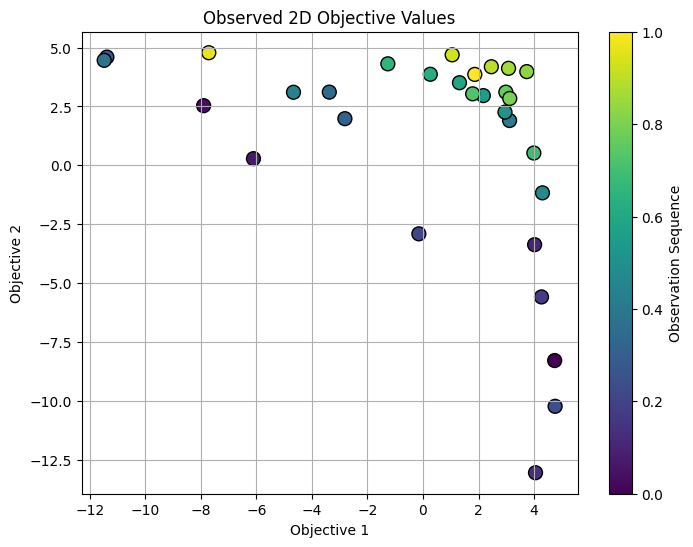

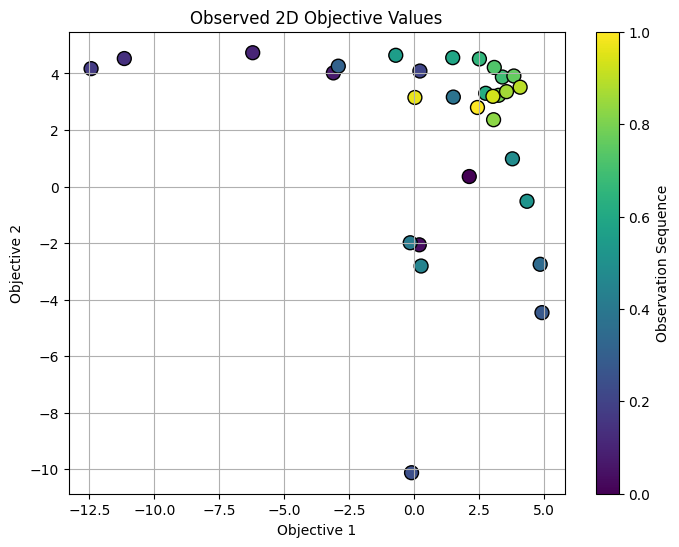

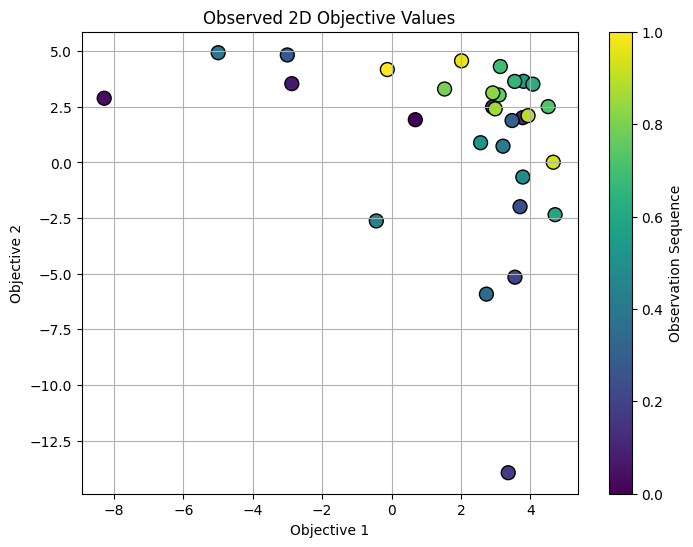

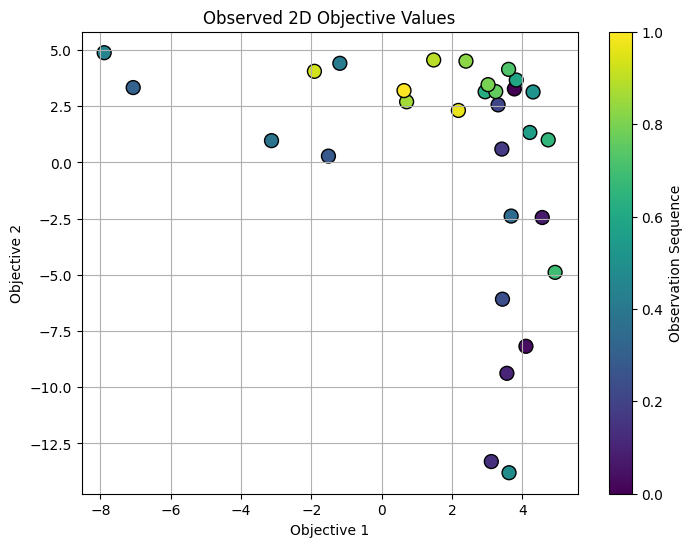

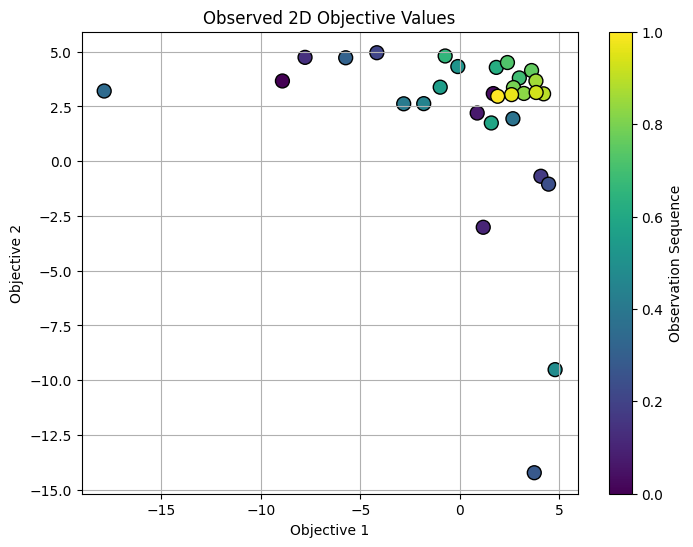

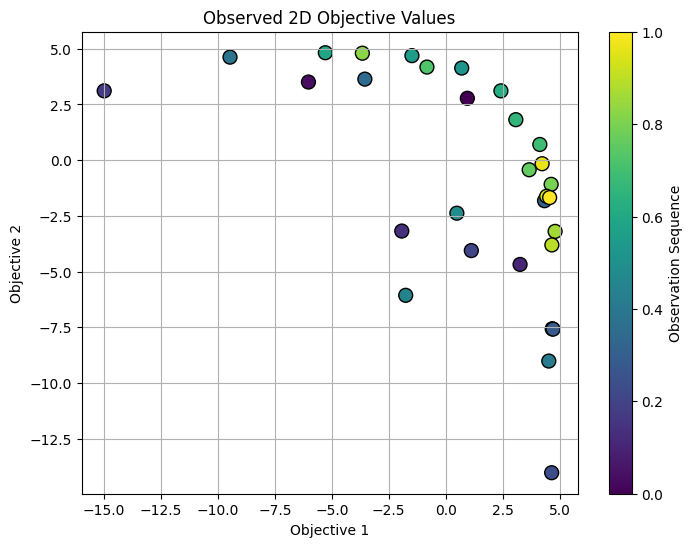

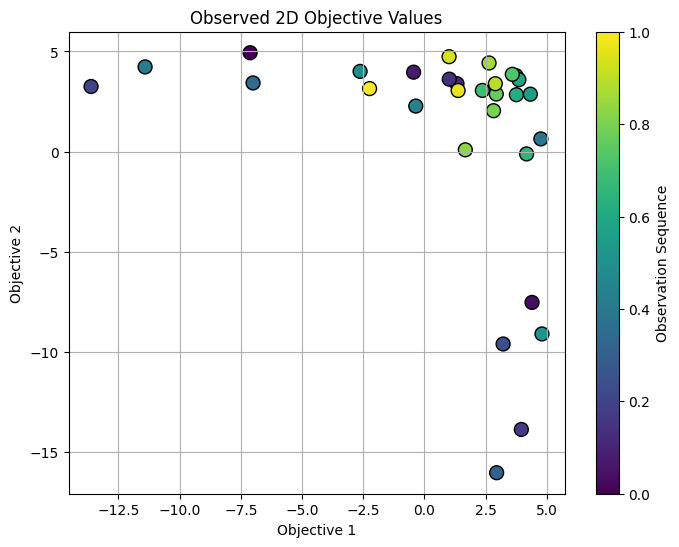

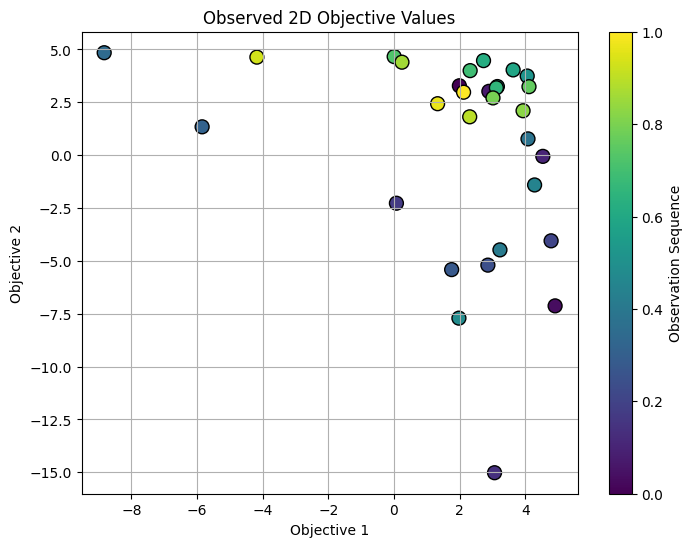

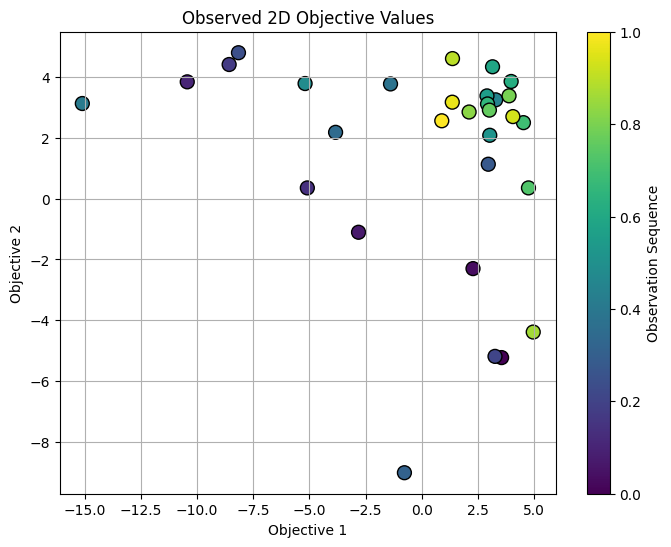

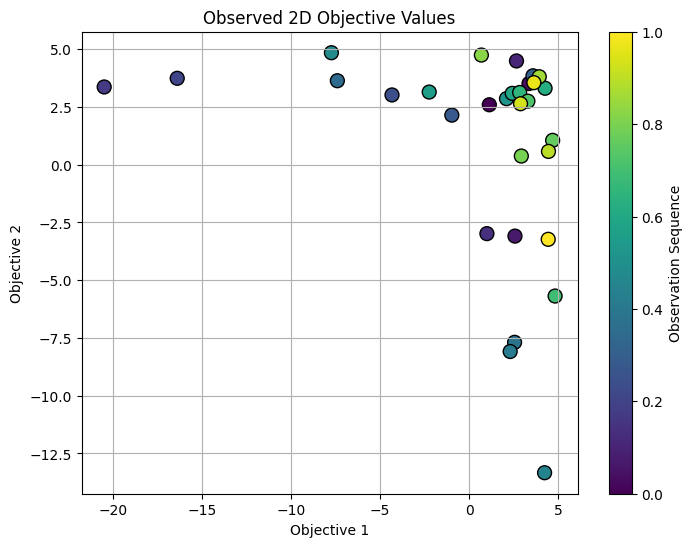

In [102]:
for i in range (MOBO_round):
    plot_2d_observations_with_gradient(all_y_observed[i])


### 4.5 A comparison baseline: only random search

In [103]:
def multi_objective_random_search(
        target_functions, bounds, num_searches, ref_point=[-30, -30]):
    """
    Multi-Objective Random Search, tracking hypervolume at each step.

    Parameters:
    - target_functions : list of callables, each being an objective function to maximize.
    - bounds : list of tuples, (lower, upper) bounds for each dimension.
    - num_searches : int, number of random search iterations.
    - ref_point : list, reference point for hypervolume calculation.

    Returns:
    - X_observed : array of observed x values.
    - Y_observed : array of observed objective values.
    - pareto_front : array of points on the final Pareto front.
    - hypervolumes : list of hypervolume values at each iteration.
    """
    num_dims = len(bounds)
    num_objectives = len(target_functions)

    # Random Initialization
    X_observed = np.random.uniform(
        [b[0] for b in bounds], [b[1] for b in bounds], size=(num_searches, num_dims)
    )
    Y_observed = np.array([[f(x) for f in target_functions] for x in X_observed])

    # Initialize the hypervolume tracking list
    hypervolumes = []

    # Track hypervolume at each iteration
    for i in range(num_searches):
        # Get the current Pareto front
        pareto_front = get_pareto_front(Y_observed[:i+1])
        # Compute the hypervolume
        hypervolume = compute_hypervolume(pareto_front, ref_point)
        hypervolumes.append(hypervolume)
        
        print(f"Random Search {i + 1}: x = {X_observed[i]}, y = {Y_observed[i]}, hypervolume = {hypervolume}")

    # Final Pareto front after all searches
    final_pareto_front = get_pareto_front(Y_observed)
    
    return X_observed, Y_observed, final_pareto_front, hypervolumes

In [104]:
# Set up target functions and reference point
target_functions = [branin, reversed_branin]
ref_point = [-30, -30]  # Reference point for hypervolume calculation

random_hvs = []
random_y_observed = []
for i in range(MOBO_round):
    print(f"\nRun {i + 1} of random search:")
    # Run Multi-Objective Bayesian Optimization
    X_observed, Y_observed, pareto_front, hvs = multi_objective_random_search(
        target_functions=target_functions,
        bounds=bounds_branin,
        num_searches=init_steps + opt_steps
    )
    random_hvs.append(hvs)
    random_y_observed.append(Y_observed)


Run 1 of random search:
Random Search 1: x = [2.90037458 1.77158365], y = [ 4.88354397 -6.64057955], hypervolume = 814.8593702668139
Random Search 2: x = [ 6.33118409 14.57702227], y = [-15.11719823   2.9948112 ], hypervolume = 958.2609808814753
Random Search 3: x = [4.37037649 5.10988502], y = [ 3.02740218 -2.69761295], hypervolume = 1029.8045342723367
Random Search 4: x = [-3.59181064  8.6375975 ], y = [ 2.61248547 -0.06458492], hypervolume = 1076.4872885676816
Random Search 5: x = [ 8.44274747 12.0982686 ], y = [-6.13155445  4.40543338], hypervolume = 1137.647290917287
Random Search 6: x = [-0.84114844  1.90612328], y = [0.30844976 0.15211506], hypervolume = 1139.0428396661007
Random Search 7: x = [0.38537996 6.70012702], y = [2.94269559 2.27266916], hypervolume = 1159.7255713360041
Random Search 8: x = [-1.21143022 10.99115281], y = [2.83660302 1.97409625], hypervolume = 1159.7255713360041
Random Search 9: x = [-2.69642178  1.90098823], y = [-3.83781754  4.51758575], hypervolume =

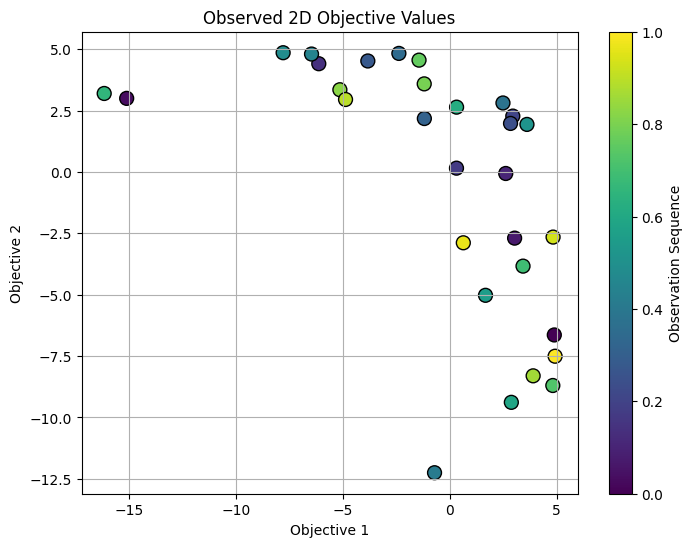

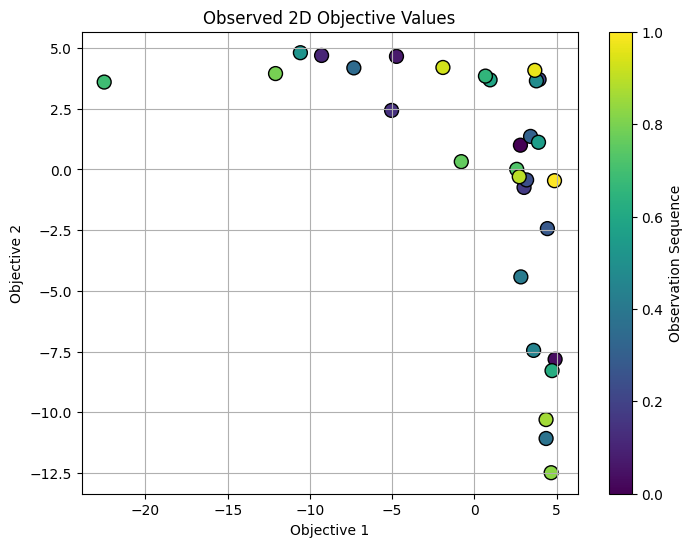

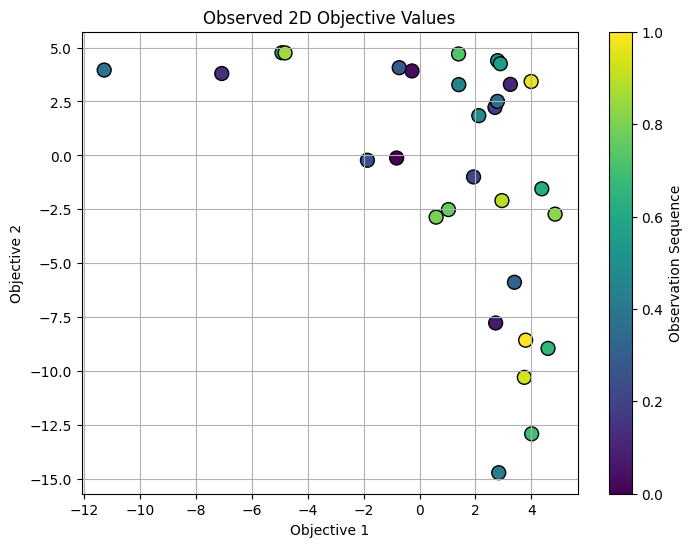

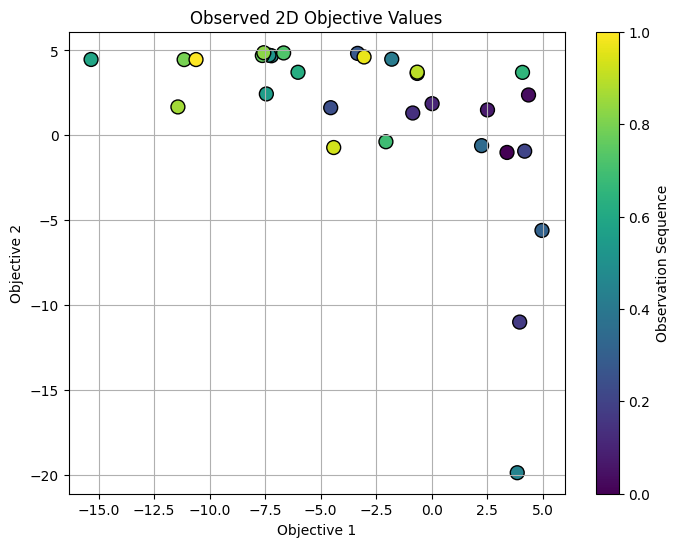

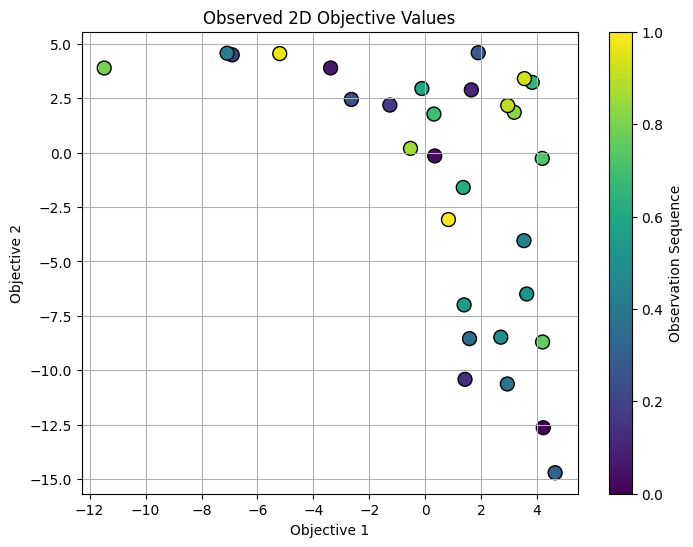

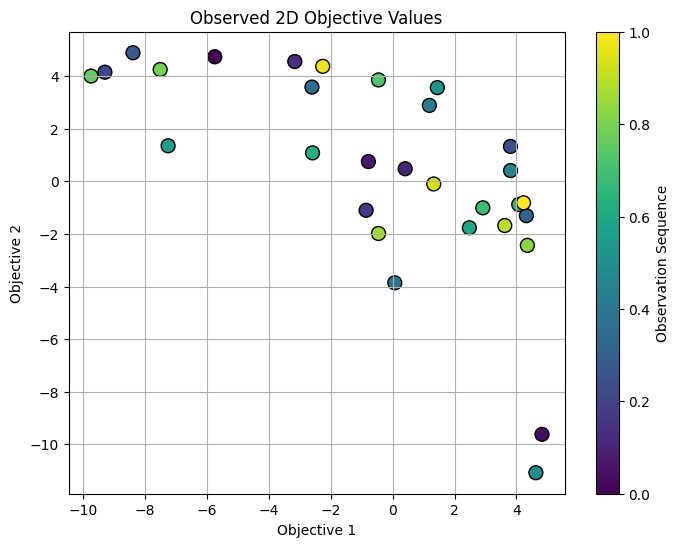

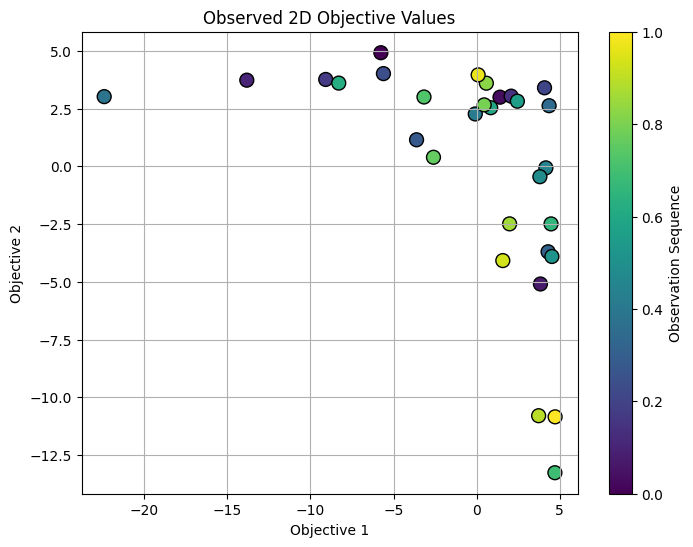

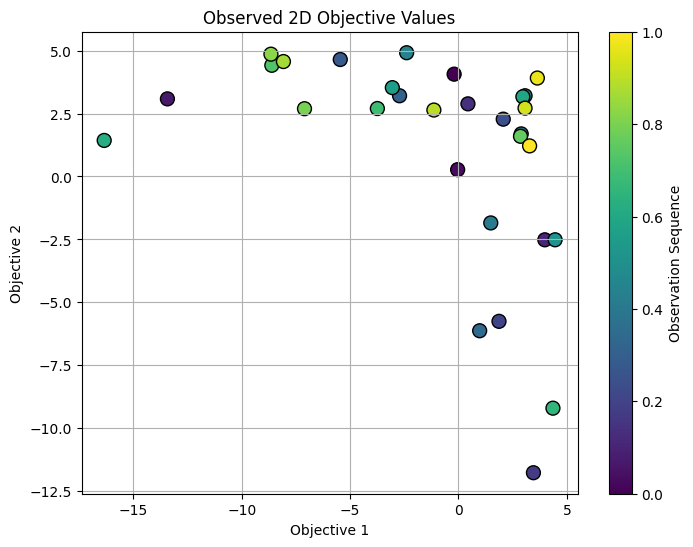

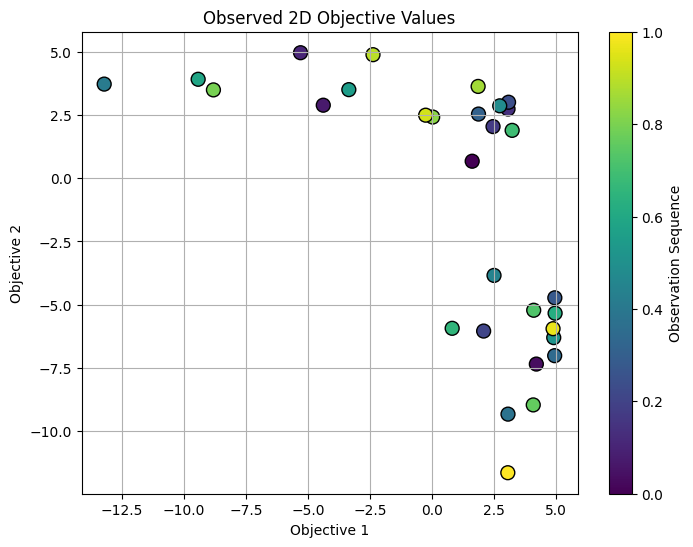

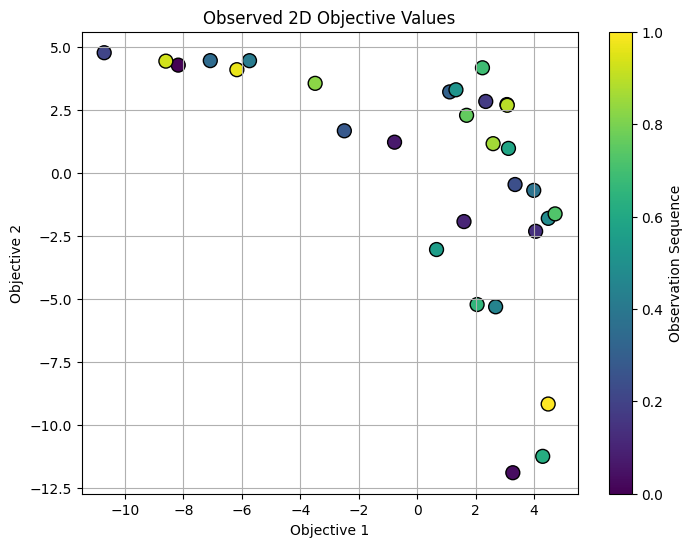

In [105]:
for i in range(MOBO_round):
    plot_2d_observations_with_gradient(random_y_observed[i])

#### Plotting the hypervolume progress

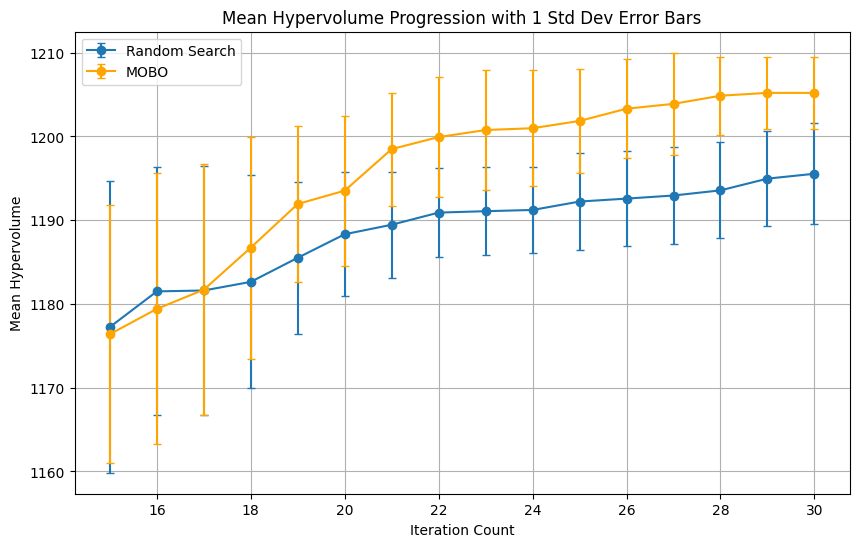

In [106]:
# Convert lists of hypervolumes to numpy arrays for easier calculations
random_hvs_array = np.array(random_hvs)  # Shape: (5 runs, 15 iterations)
mobo_hvs_array = np.array(all_hvs)       # Shape: (5 runs, 10 iterations)

# Compute mean and std for each iteration count
random_hv_means = random_hvs_array[:, init_steps - 1:].mean(axis=0)  # Starting from iteration 5
random_hv_stds = random_hvs_array[:, init_steps - 1:].std(axis=0)

mobo_hv_means = mobo_hvs_array.mean(axis=0)
mobo_hv_stds = mobo_hvs_array.std(axis=0)

# Define iteration counts for x-axis
iterations_random = np.arange(init_steps , init_steps + opt_steps + 1)  # For random search
iterations_mobo = np.arange(init_steps , init_steps + opt_steps + 1)    # For MOBO (to align with random search's length)

# Plot the mean hypervolumes with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(iterations_random, random_hv_means, yerr=random_hv_stds, fmt='-o', capsize=3, label="Random Search")
plt.errorbar(iterations_mobo, mobo_hv_means, yerr=mobo_hv_stds, fmt='-o', capsize=3, color="orange", label="MOBO")

# Labeling the plot
plt.xlabel("Iteration Count")
plt.ylabel("Mean Hypervolume")
plt.title("Mean Hypervolume Progression with 1 Std Dev Error Bars")
plt.legend()
plt.grid(True)
plt.show()

## 5. Reflection (YOUR TASK 4, 1P)

<a id="TASK4"></a>

For your own project, try to come up with one thing that Bayesian optimization can be useful for helping you make a decision. Your answer will need to include the detailed description of the problem, the design parameters, and the objective functions. 

#### Fill in your answer below (in the cell):

**Problem (what do you want to optimize for):** 
helping people be more productive and be more interested in doing housework using our task manager

**Design parameters (what parameters may have an influence):**
- order of tasks
- notification frequency
- betting values
- amt of coins given out in daily rewards
- presentation of app

**Objective functions (what metrics/measurements you want to improve):**
- task completion rate
- user retention
- user satisfaction
